# Figures for GoM trend manuscript

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import linregress
import jo_regress

### Load in data for trends

Windstress: $\tau = \rho_{air} \times C_d \times U_{10}^2$

$C_d$ = 1.25e-3 [(Kara et al., 2007)](https://doi.org/10.1175/2007JCLI1825.1)

In [2]:
sst_ds = xr.open_dataset('/work5/stb/ERA5/sst.nc', chunks={})
tcc_ds = xr.open_dataset('/work5/stb/ERA5/tcc.nc', chunks={})
mslp_ds = xr.open_dataset('/work5/stb/ERA5/mslp.nc', chunks={})
u10_ds = xr.open_dataset('/work5/stb/ERA5/u10.nc', chunks={})
v10_ds = xr.open_dataset('/work5/stb/ERA5/v10.nc', chunks={})
mask_ds = xr.open_dataset('/work5/stb/ERA5/mask.nc', chunks={})
lcc_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/lcc.nc', chunks={})
glorys = xr.open_dataset('glorys_vars.nc', chunks={})
sss_g = xr.open_dataset('cmems_mod_glo_phy_my_0.083deg_P1D-m_so_98.00W-72.00W_17.00N-31.00N_0.49-5727.92m_1993-01-01-2021-06-30.nc',
                        chunks={})
heat_fluxes = xr.open_dataset('/work/Shanice.Bailey/ERA5/era-heat-fluxes.nc', chunks={})
#hf = xr.open_dataset('/work/Shanice.Bailey/ERA5/heat-fluxes_1959-2021.nc', chunks={})
speed_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/speed.nc', chunks={})
direction_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/direction.nc', chunks={})
air_density_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/air_density.nc', chunks={})
energy_flux_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/energy_flux.nc', chunks={})

In [3]:
sst_ds

<xarray.Dataset> Size: 8GB
Dimensions:                  (latitude: 55, longitude: 69, time: 552264)
Coordinates:
  * latitude                 (latitude) float32 220B 31.0 30.75 ... 17.75 17.5
  * longitude                (longitude) float32 276B 262.0 262.2 ... 279.0
  * time                     (time) datetime64[ns] 4MB 1959-01-01 ... 2021-12...
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 8GB dask.array<chunksize=(552264, 55, 69), meta=np.ndarray>

### Process data 
> Time slice
> 
> GoM region slice
> 
> Convert heat fluxes to W m$^{-2}$)

Windstress: $\tau = \rho_{air} \times C_d \times U_{10}^2$

$C_d$ = 1.25e-3 [(Kara et al., 2007)](https://doi.org/10.1175/2007JCLI1825.1)

Windstress Curl: $Curl(\tau) = \frac{\partial \tau_y}{\partial x} - \frac{\partial \tau_x}{\partial y}$

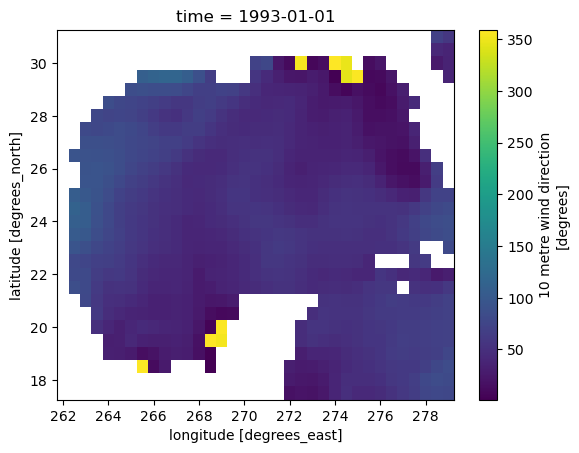

In [15]:
direction_ds.dwi[0].plot()

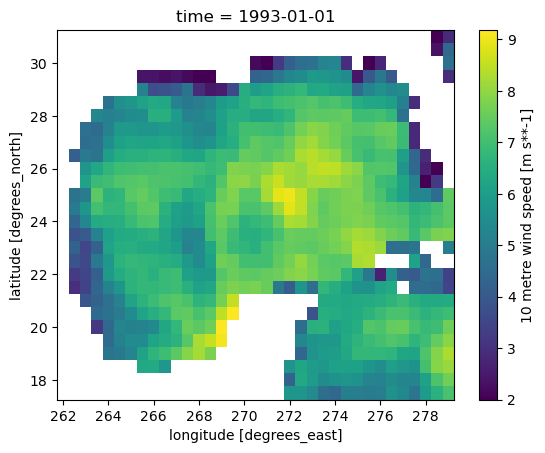

In [5]:
speed_ds.wind[0].plot()

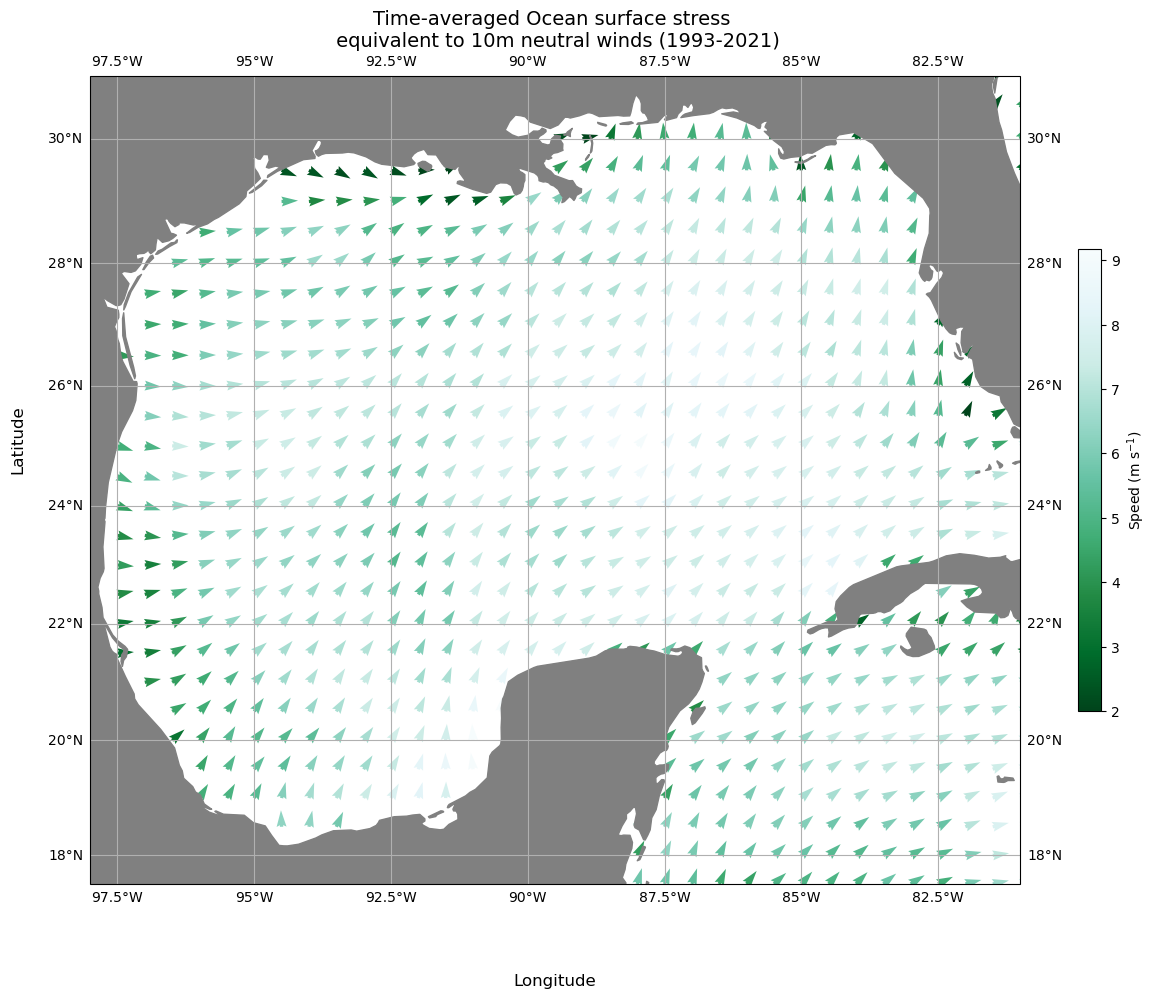

In [21]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
C = speed_ds.wind[0] # Magnitude of the vectors for coloring
U = np.sin(np.deg2rad(direction_ds.dwi[0]))
V = np.cos(np.deg2rad(direction_ds.dwi[0]))
im = ax.quiver(speed_ds.longitude, 
               speed_ds.latitude, 
               U.values, 
               V.values,
               C, cmap='BuGn_r', width=0.004, transform=ccrs.PlateCarree())#, 'green', 'red']))#, vmin=34, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Speed (m s$^{-1}$)")

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Time-averaged Ocean surface stress \n equivalent to 10m neutral winds (1993-2021)', fontsize=14);

In [5]:
speed_magnitude = speed_ds.wind[0] # Magnitude of the vectors for coloring
u_component = np.sin(np.deg2rad(direction_ds.dwi[0]))
v_component = np.cos(np.deg2rad(direction_ds.dwi[0]))

In [6]:
time_slice = dict(time=slice('2000', '2021-06-30'))
gom = dict(longitude=slice(-98, -81), latitude=slice(17.5, 31))

glorys_gom = glorys.sel(**gom).isel(depth=0).drop_vars('depth').sel(**time_slice)
sst = sst_ds.sea_surface_temperature.sel(**time_slice)
tcc = tcc_ds.total_cloud_cover.sel(**time_slice)
mslp = mslp_ds.mean_sea_level_pressure.sel(**time_slice)
u10 = u10_ds['10m_u_component_of_wind'].sel(**time_slice)
v10 = v10_ds['10m_v_component_of_wind'].sel(**time_slice)
mask = mask_ds.land_sea_mask
lcc = lcc_ds.lcc.sel(**time_slice)

ef = energy_flux_ds.phioc
air_density = air_density_ds.rhoao
tauu = 1.25e-3 * air_density * (speed_magnitude*u_component)**2
tauv = 1.25e-3 * air_density * (speed_magnitude*v_component)**2
wsc = ((tauv.diff('longitude') / tauv.longitude.diff('longitude'))
      - tauu.diff('latitude') / tauu.latitude.diff('latitude'))

sw = heat_fluxes.ssr.sel(**time_slice) / (60*60) #W/m2
lw = heat_fluxes.str.sel(**time_slice) / (60*60) #W/m2
sh = heat_fluxes.sshf.sel(**time_slice) / (60*60) #W/m2
lh = heat_fluxes.slhf.sel(**time_slice) / (60*60) #W/m2

sst_g = glorys_gom.thetao
sss_g = sss_g.so.sel(**gom).isel(depth=0).drop_vars('depth').sel(**time_slice)
ssh = glorys_gom.zos
u = glorys_gom.uo
v = glorys_gom.vo
eke = 0.5 * (u**2 + v**2)

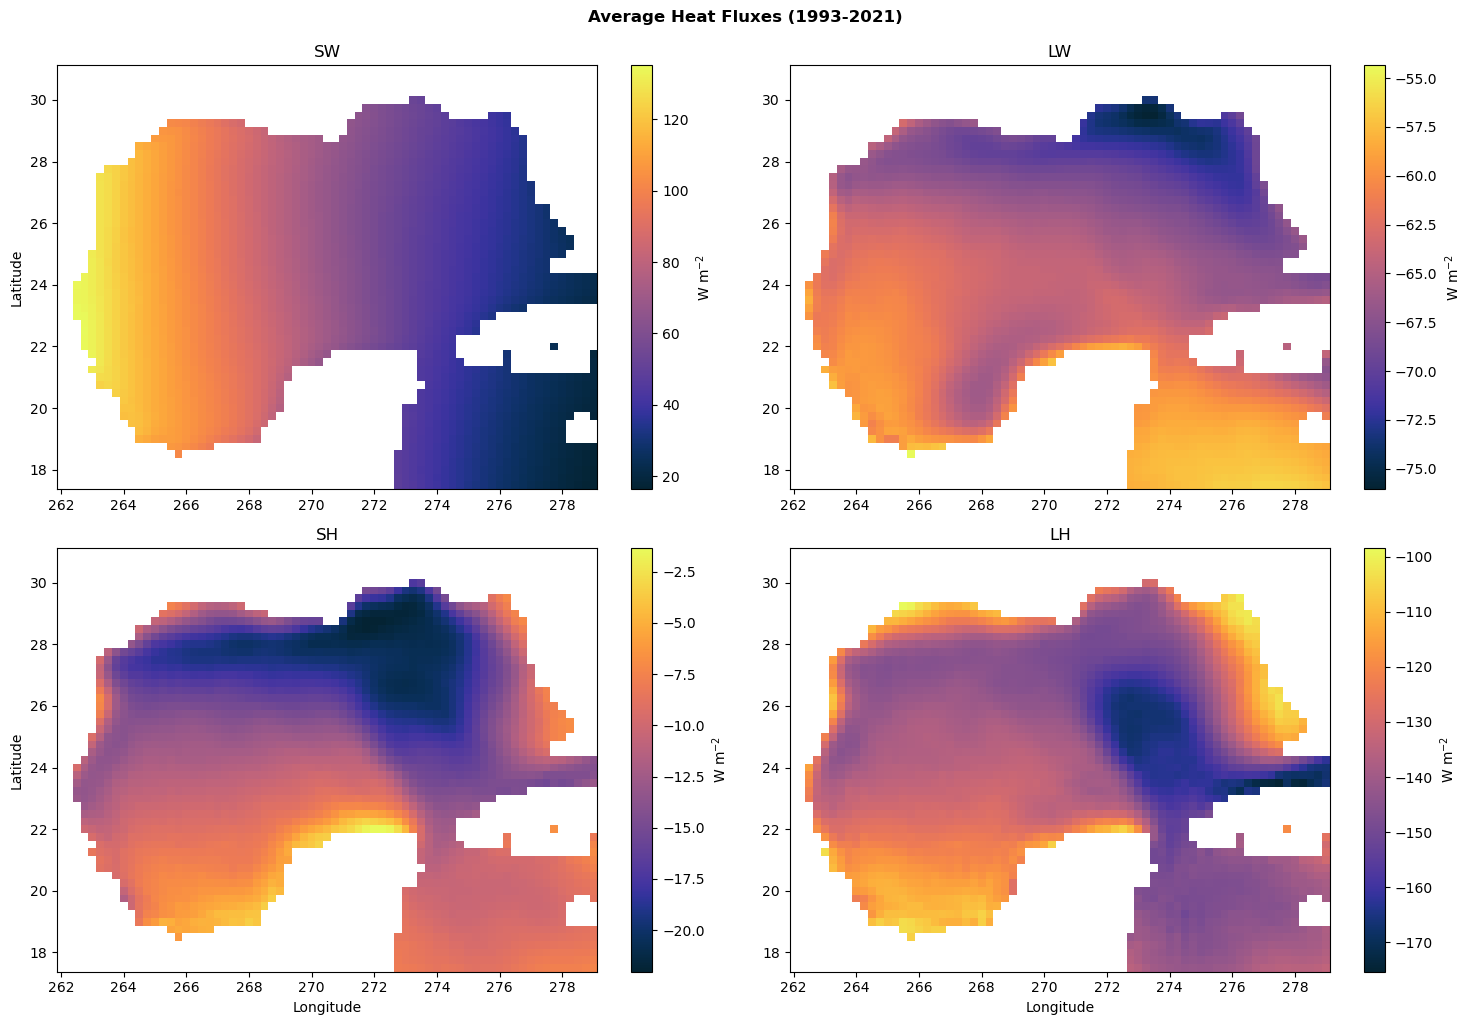

In [6]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
sw.where(mask==0).mean('time').plot(ax=ax[0,0], cmap=cmocean.cm.thermal, cbar_kwargs={'label':r'W m$^{-2}$'})
lw.where(mask==0).mean('time').plot(ax=ax[0,1], cmap=cmocean.cm.thermal, cbar_kwargs={'label':r'W m$^{-2}$'})
sh.where(mask==0).mean('time').plot(ax=ax[1,0], cmap=cmocean.cm.thermal, cbar_kwargs={'label':r'W m$^{-2}$'})
lh.where(mask==0).mean('time').plot(ax=ax[1,1], cmap=cmocean.cm.thermal, cbar_kwargs={'label':r'W m$^{-2}$'})
ax[0,0].set_title('SW')
ax[0,1].set_title('LW')
ax[1,0].set_title('SH')
ax[1,1].set_title('LH')
ax[0,0].set_ylabel('Latitude')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[1,0].set_ylabel('Latitude')
ax[1,0].set_xlabel('Longitude')
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('Longitude')
plt.tight_layout()
plt.suptitle('Average Heat Fluxes (1993-2021)', fontweight='bold', y=1.02);

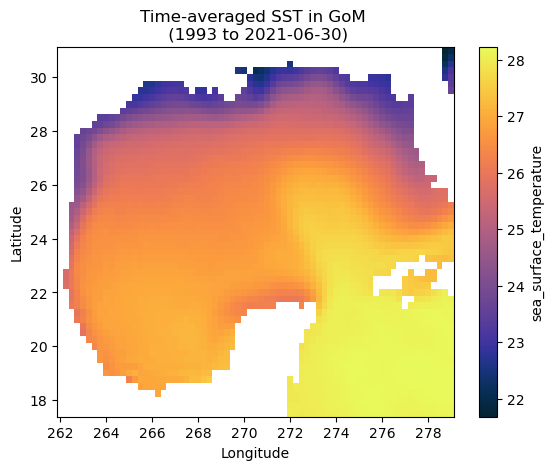

In [26]:
sst.mean('time').plot(cmap=cmocean.cm.thermal)
plt.title('Time-averaged SST in GoM \n (1993 to 2021-06-30)')
plt.xlabel('Longitude')
plt.ylabel('Latitude');

### Calculate linear trend for each data field

In [7]:
#linear regression at every grid cell over time, so that we see trend rate at each grid pt
# Calculate the linear trend at each grid point
def trending(da):
    d = da.groupby('time.year').mean('time').polyfit('year', deg=1, skipna=True, cov=True)

    return d

In [8]:
#era5 vars
trend_sst = trending(sst)
trend_tcc = trending(tcc)
trend_u10 = trending(u10)
trend_v10 = trending(v10)
trend_mslp = trending(mslp)
trend_lcc = trending(lcc)
trend_ef = trending(ef)
trend_ad = trending(air_density)
trend_tauu = trending(tauu)
trend_tauv = trending(tauv)
trend_wsc = trending(wsc)
#heat fluxes
trend_sw = trending(sw)
trend_lw = trending(lw)
trend_sh = trending(sh)
trend_lh = trending(lh)
#glorys vars
trend_sst_g = trending(sst_g)
trend_sss_g = trending(sss_g)
trend_ssh = trending(ssh)
trend_u = trending(u)
trend_v = trending(v)
trend_eke = trending(eke)

In [8]:
trend_sst

<xarray.Dataset> Size: 213kB
Dimensions:               (degree: 2, latitude: 55, longitude: 69, cov_i: 2,
                           cov_j: 2)
Coordinates:
  * degree                (degree) int64 16B 1 0
  * latitude              (latitude) float32 220B 31.0 30.75 30.5 ... 17.75 17.5
  * longitude             (longitude) float32 276B 262.0 262.2 ... 278.8 279.0
Dimensions without coordinates: cov_i, cov_j
Data variables:
    polyfit_coefficients  (degree, latitude, longitude) float64 61kB dask.array<chunksize=(2, 55, 69), meta=np.ndarray>
    polyfit_residuals     (latitude, longitude) float64 30kB dask.array<chunksize=(55, 69), meta=np.ndarray>
    polyfit_covariance    (cov_i, cov_j, latitude, longitude) float64 121kB dask.array<chunksize=(2, 2, 55, 69), meta=np.ndarray>

In [9]:
#calculate polynomials associated with the linear trend
#purpose is to prep the data to have time dim for
#next step - which is to run eof on the outputs (the polynomials)
def polyval(da, trend_da):
    p = xr.polyval(coord=da.groupby('time.year').mean('time').year, coeffs=trend_da.polyfit_coefficients)
    return p

In [9]:
p_sst = polyval(sst, trend_sst)
p_tcc = polyval(tcc, trend_tcc)
p_u10 = polyval(u10, trend_u10)
p_v10 = polyval(v10, trend_v10)
p_mslp = polyval(mslp, trend_mslp)
p_lcc = polyval(lcc, trend_lcc)

p_sw = polyval(sw, trend_sw)
p_lw = polyval(lw, trend_lw)
p_sh = polyval(sh, trend_sh)
p_lh = polyval(lh, trend_lh)

p_sst_g = polyval(sst_g, trend_sst_g)
p_ssh = polyval(ssh, trend_ssh)
p_u = polyval(u, trend_u)
p_v = polyval(v, trend_v)
p_eke = polyval(eke, trend_eke)

In [10]:
p_sst

<xarray.DataArray (year: 29, latitude: 55, longitude: 69)> Size: 880kB
dask.array<add, shape=(29, 55, 69), dtype=float64, chunksize=(29, 55, 69), chunktype=numpy.ndarray>
Coordinates:
  * year       (year) int64 232B 1993 1994 1995 1996 ... 2018 2019 2020 2021
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0

## Trends (spatial maps)

In [10]:
print('Max: ', trend_wsc.polyfit_coefficients[0].max().values, 'Pa/yr', 
      '\nMin: ', trend_wsc.polyfit_coefficients[0].min().values, 'Pa/yr')

Max:  7.085203008027505e-06 Pa/yr 
Min:  -4.92280601860355e-06 Pa/yr


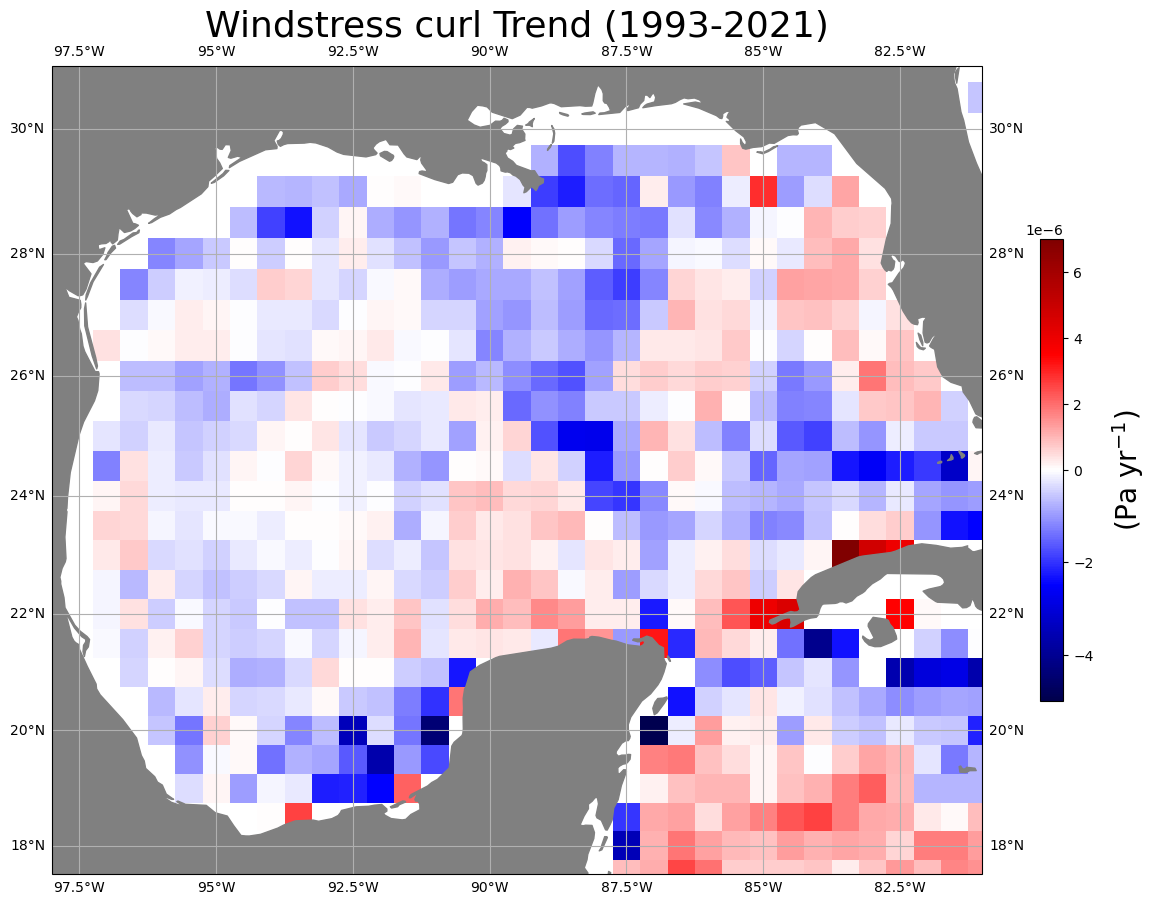

In [34]:
plot_trend(trend_wsc, 'Windstress curl Trend (1993-2021)', 'WSC', '(Pa yr$^{-1}$)', 
           -5e-06, 7e-06, cmap_choice='seismic')

/nbhome/Shanice.Bailey/conda/envs/bai_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'vcenter'
  result = super().contourf(*args, **kwargs)


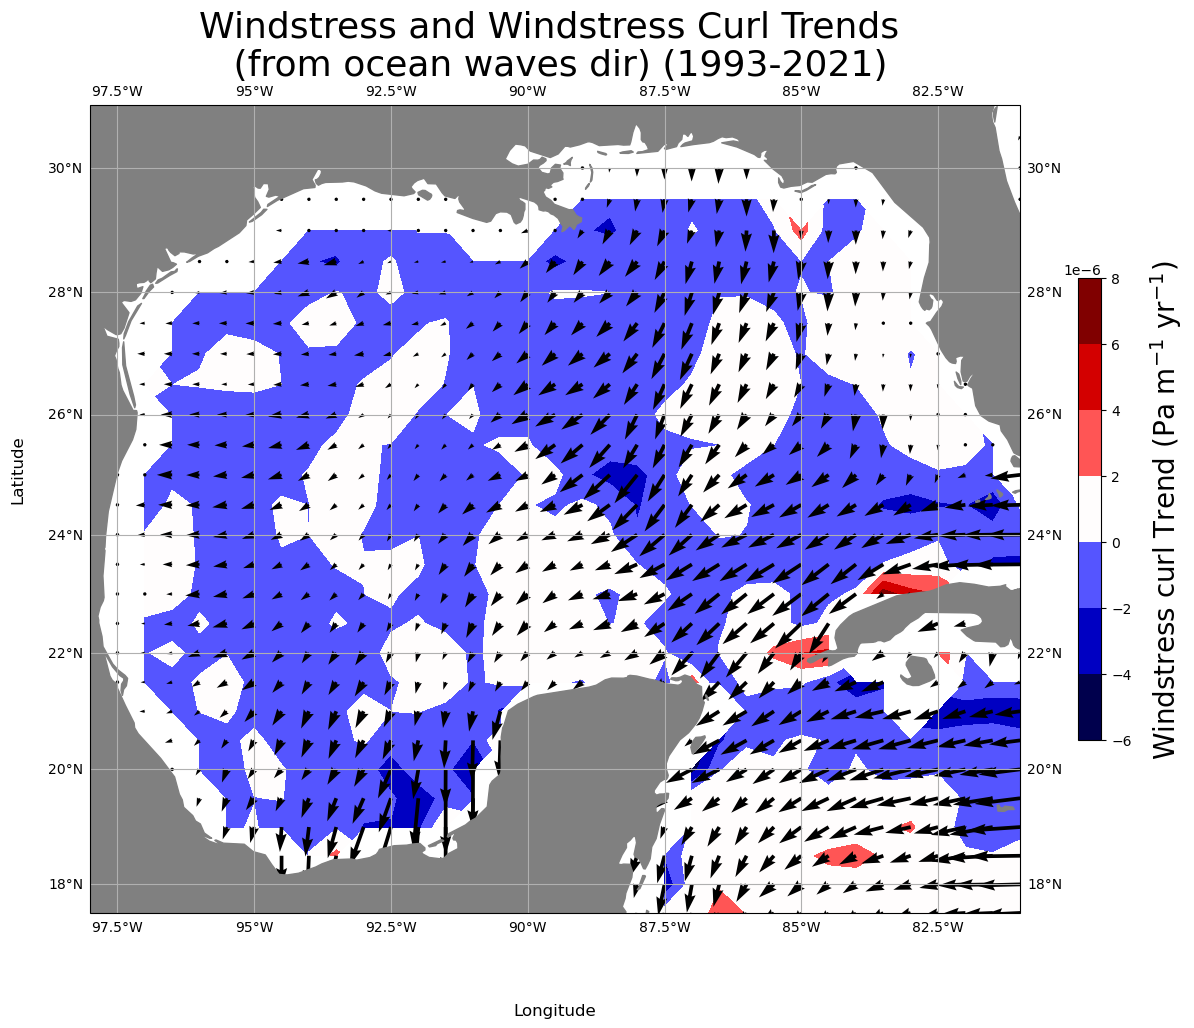

In [53]:
#positive windstress curl is upwelling
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
U = trend_tauu.polyfit_coefficients[0][1:,1:]
V = trend_tauv.polyfit_coefficients[0][1:,1:]
#C = ds.wsc.mean('time')
cf = ax.contourf(trend_wsc.longitude, trend_wsc.latitude, trend_wsc.polyfit_coefficients[0], cmap='seismic', 
                 vmin=-5e-06, vcenter=0, vmax=7e-06, transform=ccrs.PlateCarree())
im = ax.quiver(trend_wsc.longitude, trend_wsc.latitude,
               U.values, 
               V.values,
               color='k', width=0.004, transform=ccrs.PlateCarree())#, 'green', 'red']))#, vmin=34, vmax=35)
cb = fig.colorbar(cf, ax=ax, shrink=0.4)
cb.set_label(r"Windstress curl Trend (Pa m$^{-1}$ yr$^{-1}$)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Windstress and Windstress Curl Trends \n (from ocean waves dir) (1993-2021)', fontsize=26);
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/trend_spatio_wsc-over-winds.pdf');

In [9]:
def plot_trend(da, title, var_title, cbar_label, v_min, v_max, cmap_choice, diverge=True):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))
    
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    if diverge==True:
        d = da.polyfit_coefficients[0]
        norm = TwoSlopeNorm(vmin=v_min, vcenter=0, vmax=v_max)
        im = ax.pcolormesh(d.longitude, d.latitude, d, transform=ccrs.PlateCarree(), 
                           norm=norm, cmap=cmap_choice)
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        
        plt.title(f'{title}', fontsize=26);
    else:
        d = da.polyfit_coefficients[0]
        im = ax.pcolormesh(d.longitude, d.latitude, d, transform=ccrs.PlateCarree(), 
                           vmin=v_min, vmax=v_max, cmap=cmap_choice)#norm=LogNorm(),
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        
        plt.title(f'{title}', fontsize=26)
    #plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/trend_spatio_{var_title}.pdf');

In [9]:
print('Max: ', trend_ef.polyfit_coefficients[0].max().values, '/yr', 
      '\nMin: ', trend_ef.polyfit_coefficients[0].min().values, '/yr')

Max:  0.0050234005301865526 /yr 
Min:  -0.01219838344279065 /yr


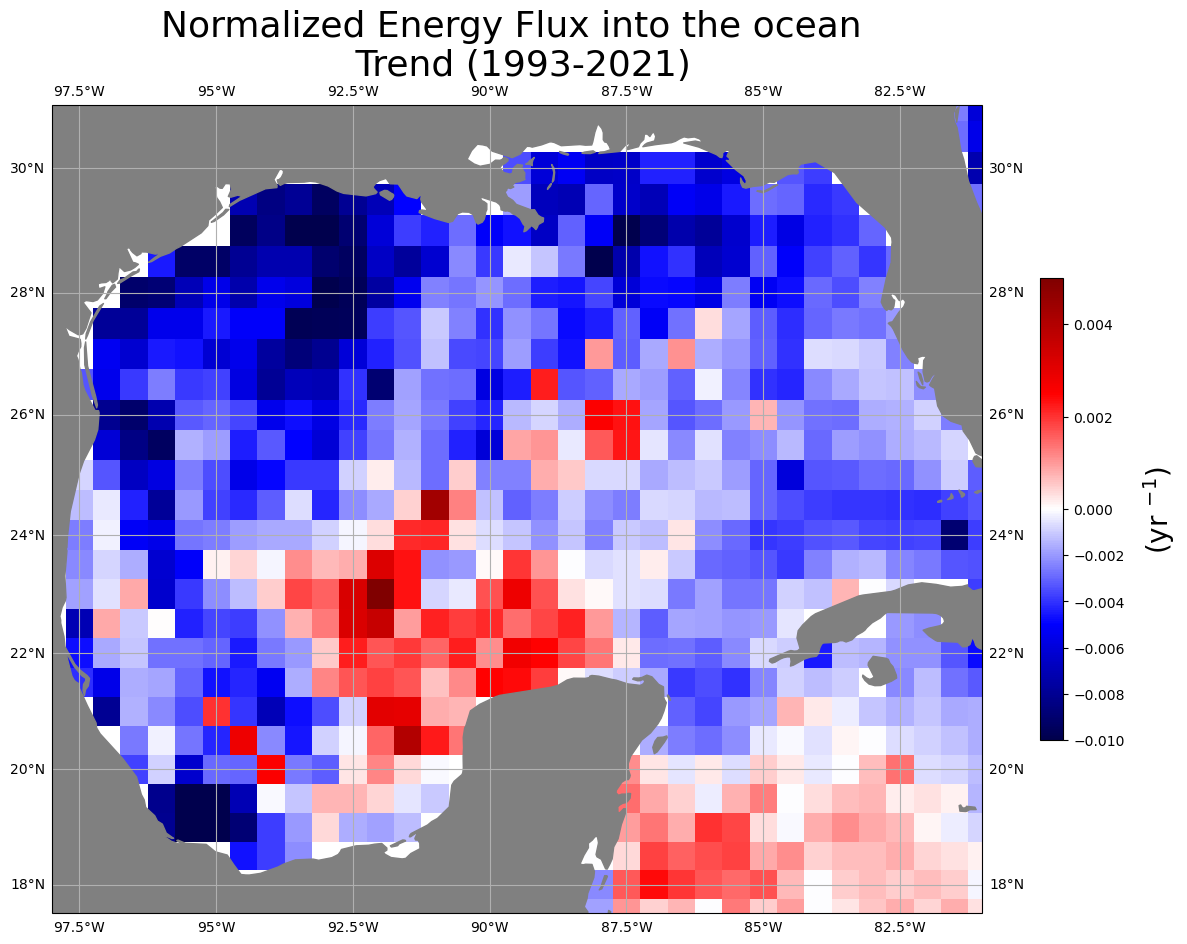

In [10]:
plot_trend(trend_ef, 'Normalized Energy Flux into the ocean \n Trend (1993-2021)', 'EF', '(yr $^{-1}$)', 
           -0.01, 0.005, cmap_choice='seismic')

In [11]:
print('Max: ', trend_ad.polyfit_coefficients[0].max().values, 'kg/m3/yr', 
      '\nMin: ', trend_ad.polyfit_coefficients[0].min().values, 'kg/m3/yr')

Max:  8.064720966891788e-06 kg/m3/yr 
Min:  -8.544785111682819e-05 kg/m3/yr


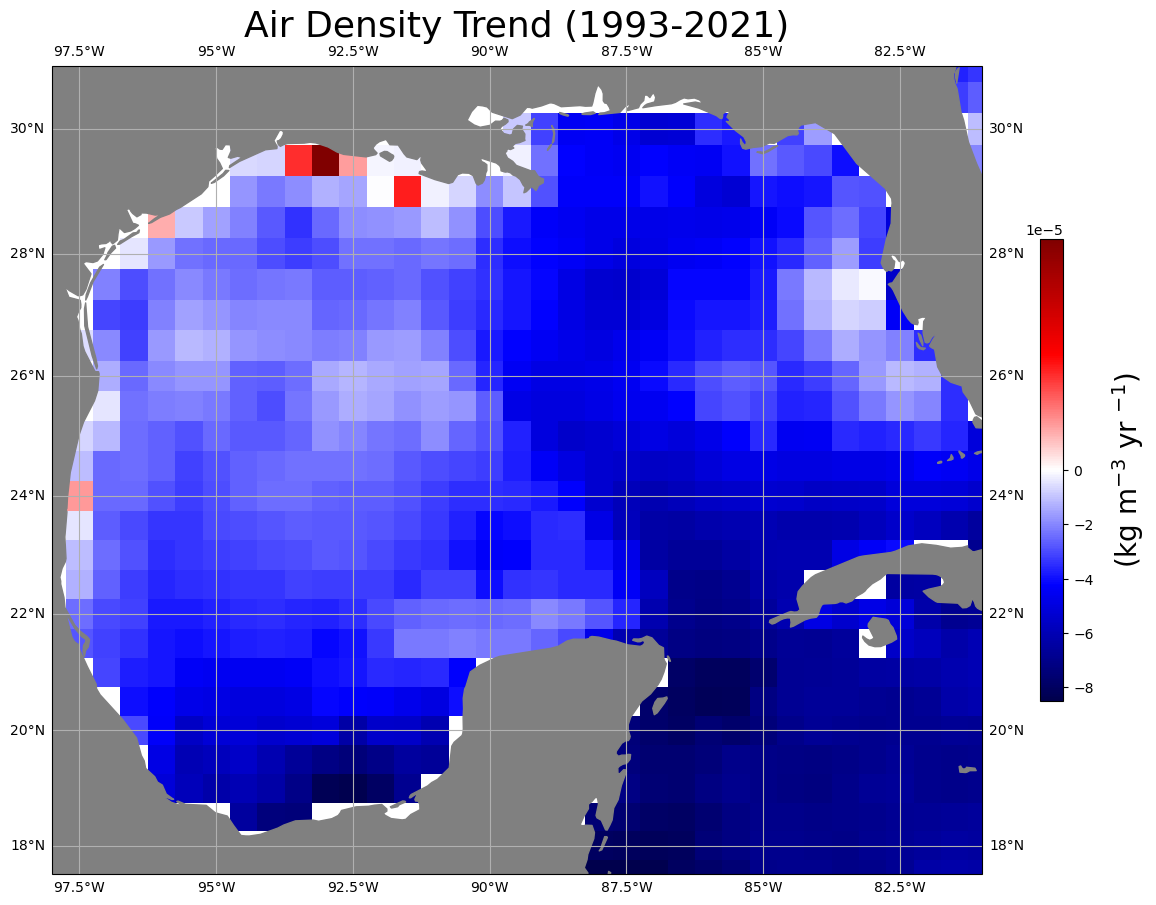

In [12]:
plot_trend(trend_ad, 'Air Density Trend (1993-2021)', 'AD', '(kg m$^{-3}$ yr $^{-1}$)', 
           -8.5e-05, 8e-06, cmap_choice='seismic')

In [13]:
print('Max: ', trend_tau.polyfit_coefficients[0].max().values, '/yr', 
      '\nMin: ', trend_tau.polyfit_coefficients[0].min().values, '/yr')

Max:  0.00020553656750638456 /yr 
Min:  -0.0002798100137878844 /yr


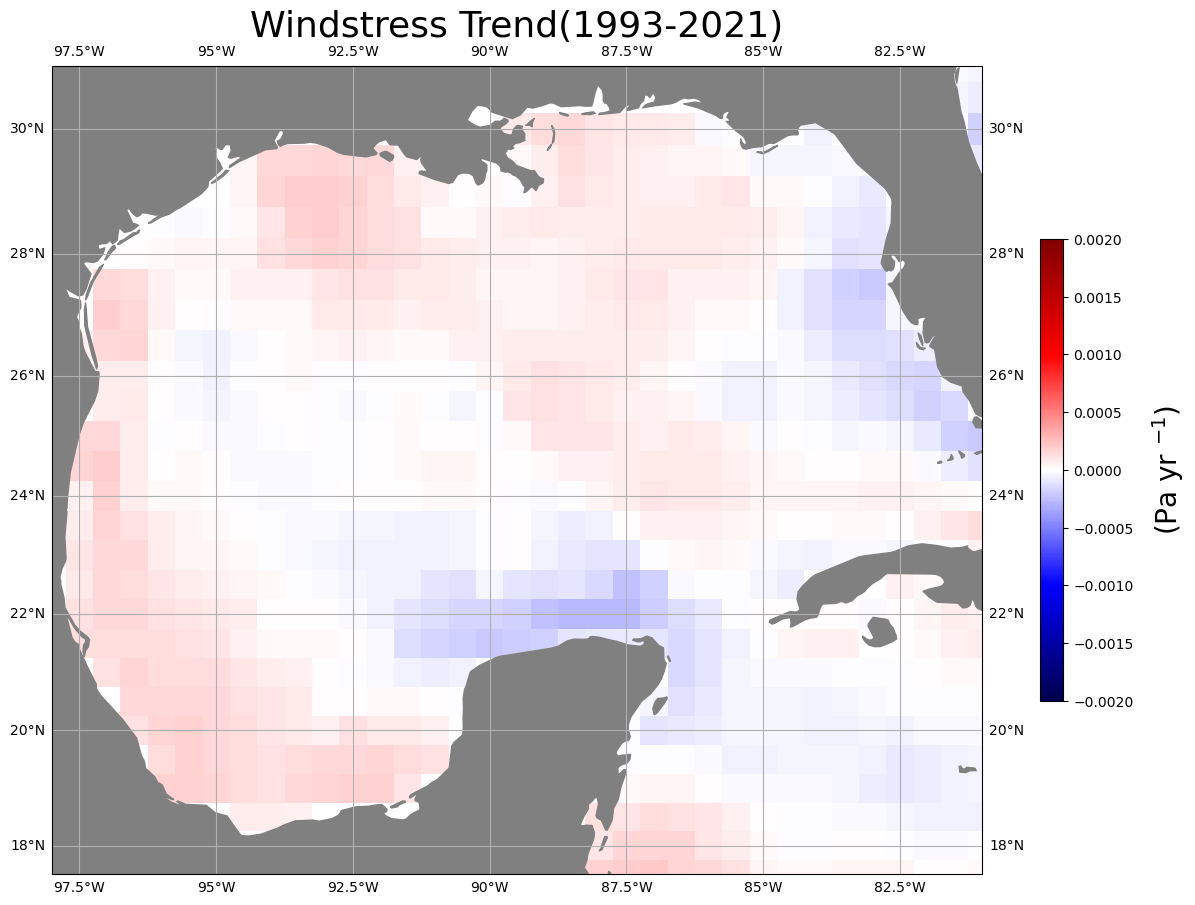

In [14]:
plot_trend(trend_tau, 'Windstress Trend(1993-2021)', 'TAU', '(Pa yr $^{-1}$)', 
           -2e-03, 2e-03, cmap_choice='seismic')

In [10]:
print('Max: ', trend_sst.polyfit_coefficients[0].max().values, '˚C/yr', 
      '\nMin: ', trend_sst.polyfit_coefficients[0].min().values, '˚C/yr')

Max:  0.06638406078267241 ˚C/yr 
Min:  -0.03858275389280781 ˚C/yr


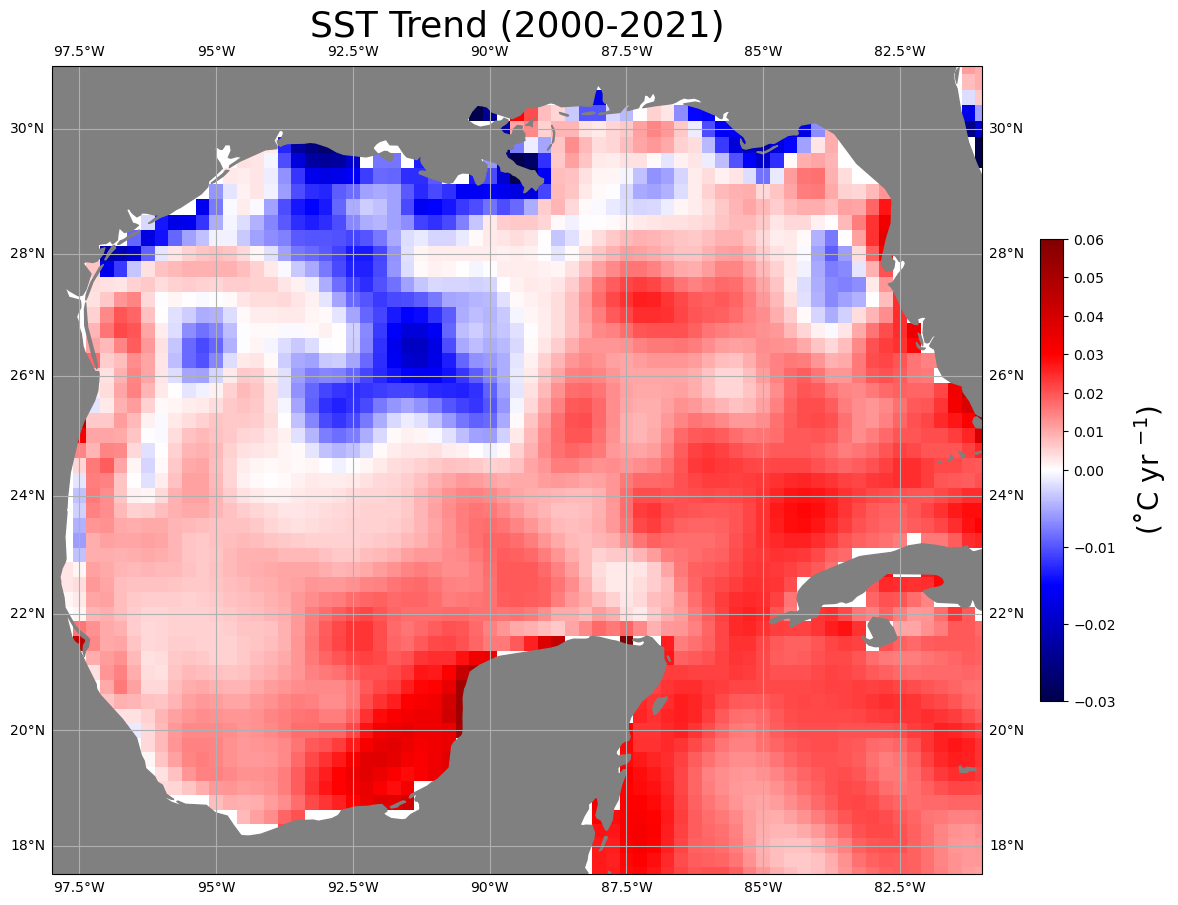

In [12]:
plot_trend(trend_sst, 'SST Trend (2000-2021)', 'SST', '(˚C yr $^{-1}$)', 
           -0.03, 0.06, cmap_choice='seismic')

In [13]:
print('Max: ', trend_sst_g.polyfit_coefficients[0].max().values, '˚C/yr', 
      '\nMin: ', trend_sst_g.polyfit_coefficients[0].min().values, '˚C/yr')

Max:  0.041610587268808466 ˚C/yr 
Min:  -0.05724453985485234 ˚C/yr


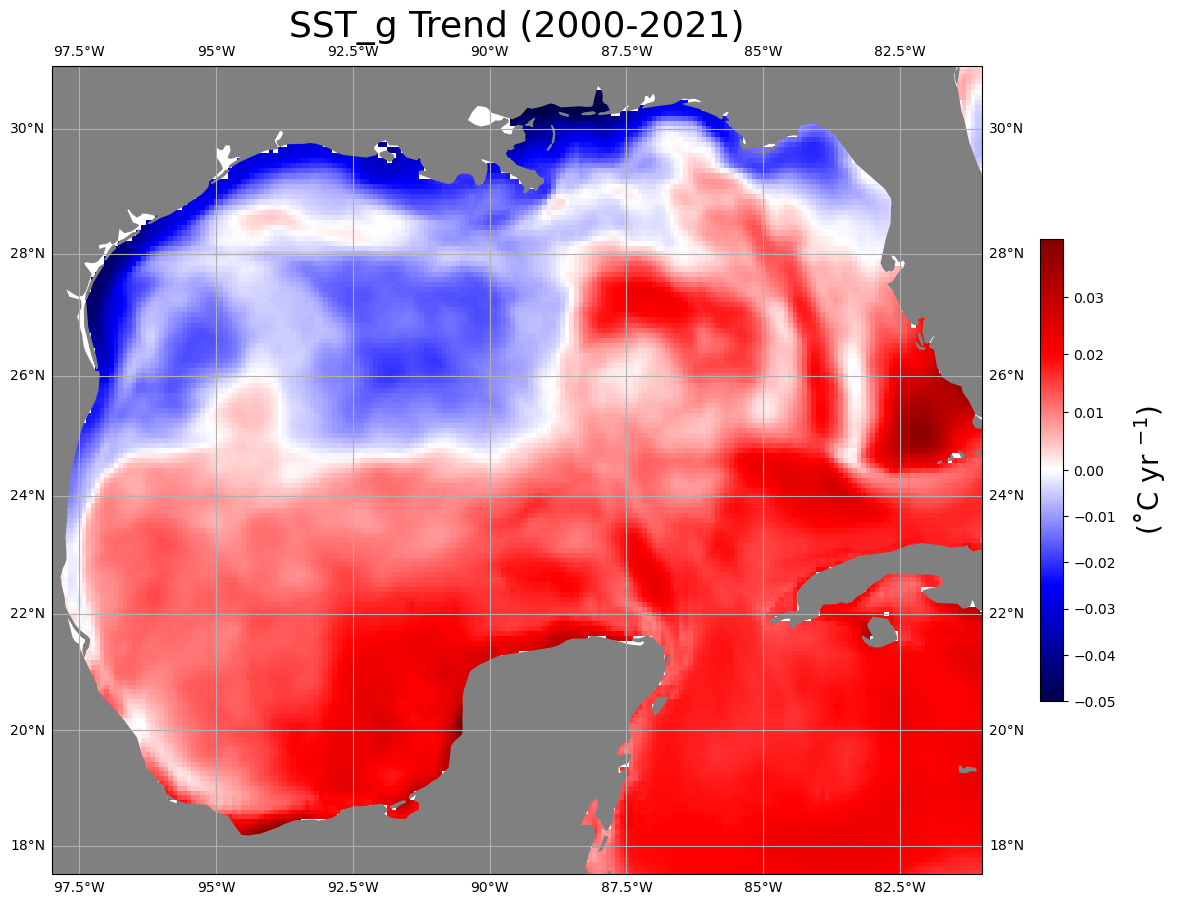

In [15]:
plot_trend(trend_sst_g, 'SST_g Trend (2000-2021)', 'SST_g', '(˚C yr $^{-1}$)', 
           -0.05, 0.04, cmap_choice='seismic')

In [13]:
print('Max: ', trend_sss_g.polyfit_coefficients[0].max().values, 'Psu/yr', 
      '\nMin: ', trend_sss_g.polyfit_coefficients[0].min().values, 'Psu/yr')

Max:  0.04138982354528345 Psu/yr 
Min:  -0.06518171660870631 Psu/yr


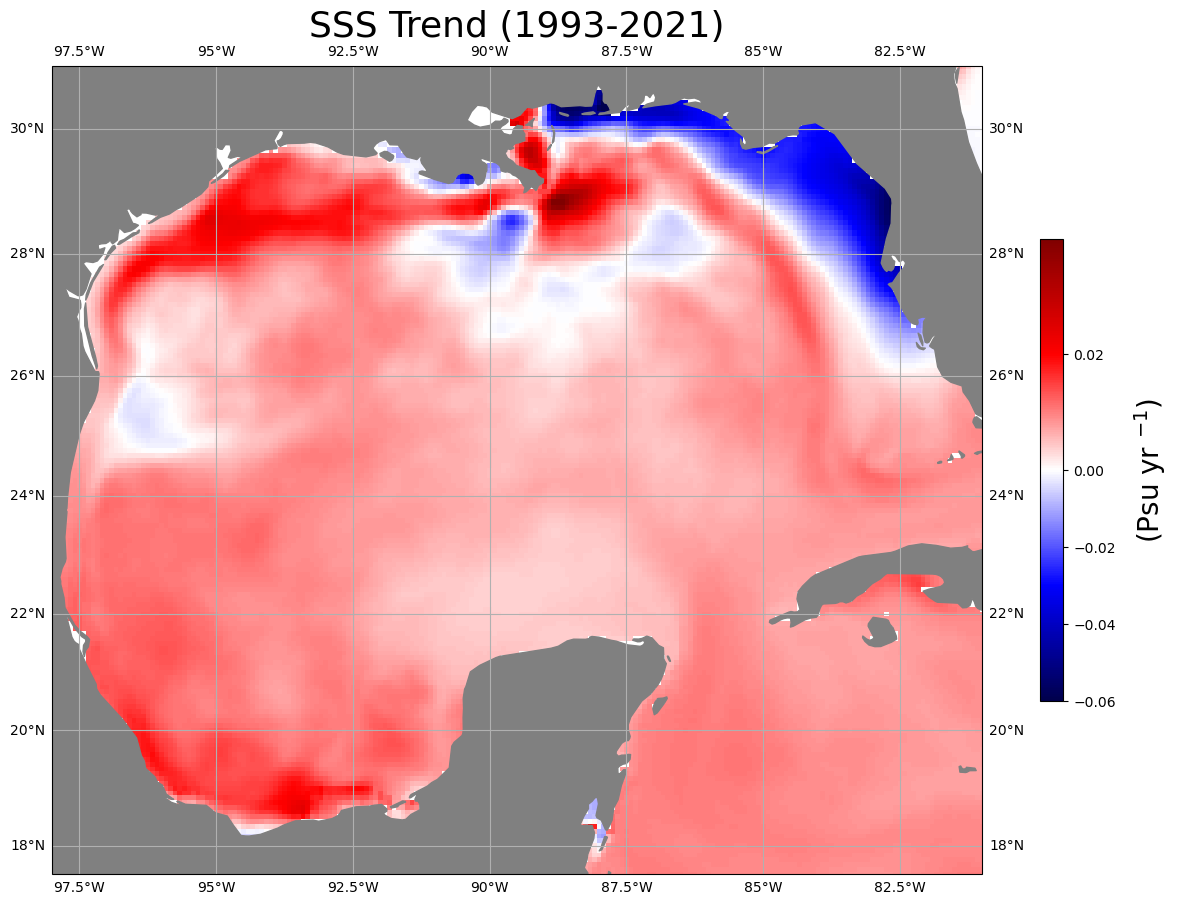

In [18]:
plot_trend(trend_sss_g, 'SSS Trend (1993-2021)', 'SSS', '(Psu yr $^{-1}$)', 
           -0.06, 0.04, cmap_choice='seismic')

In [17]:
print('Max: ', trend_tcc.polyfit_coefficients[0].max().values, 'frac/yr', 
      '\nMin: ', trend_tcc.polyfit_coefficients[0].min().values, 'frac/yr')

Max:  0.003308315802677439 frac/yr 
Min:  -0.0012246471907704866 frac/yr


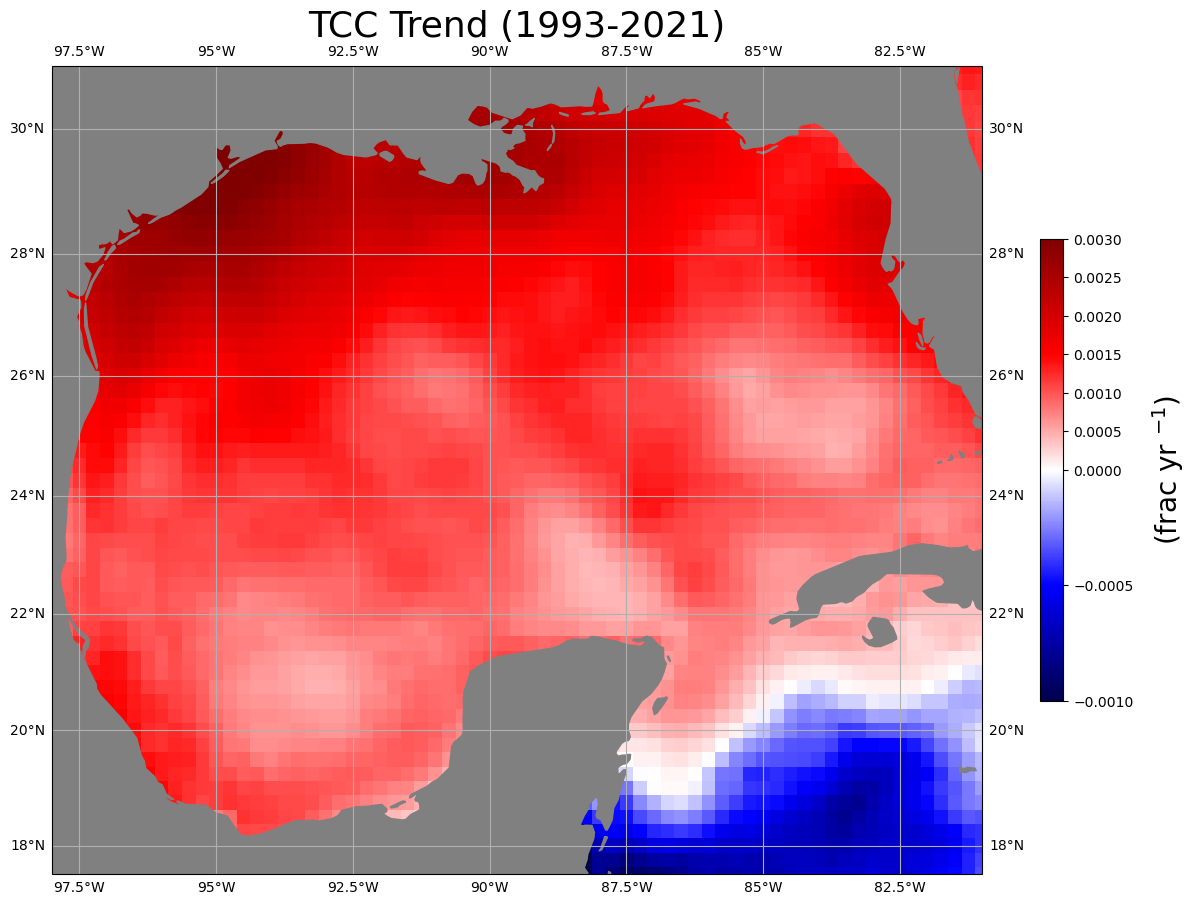

In [84]:
plot_trend(trend_tcc, 'TCC Trend (1993-2021)', 'TCC', '(frac yr $^{-1}$)', -0.001, 0.003, cmap_choice='seismic')

In [20]:
print('Max: ', trend_lcc.polyfit_coefficients[0].max().values, 'frac/yr', 
      '\nMin: ', trend_lcc.polyfit_coefficients[0].min().values, 'frac/yr')

Max:  0.0025543250321752482 frac/yr 
Min:  -0.0019290250027619756 frac/yr


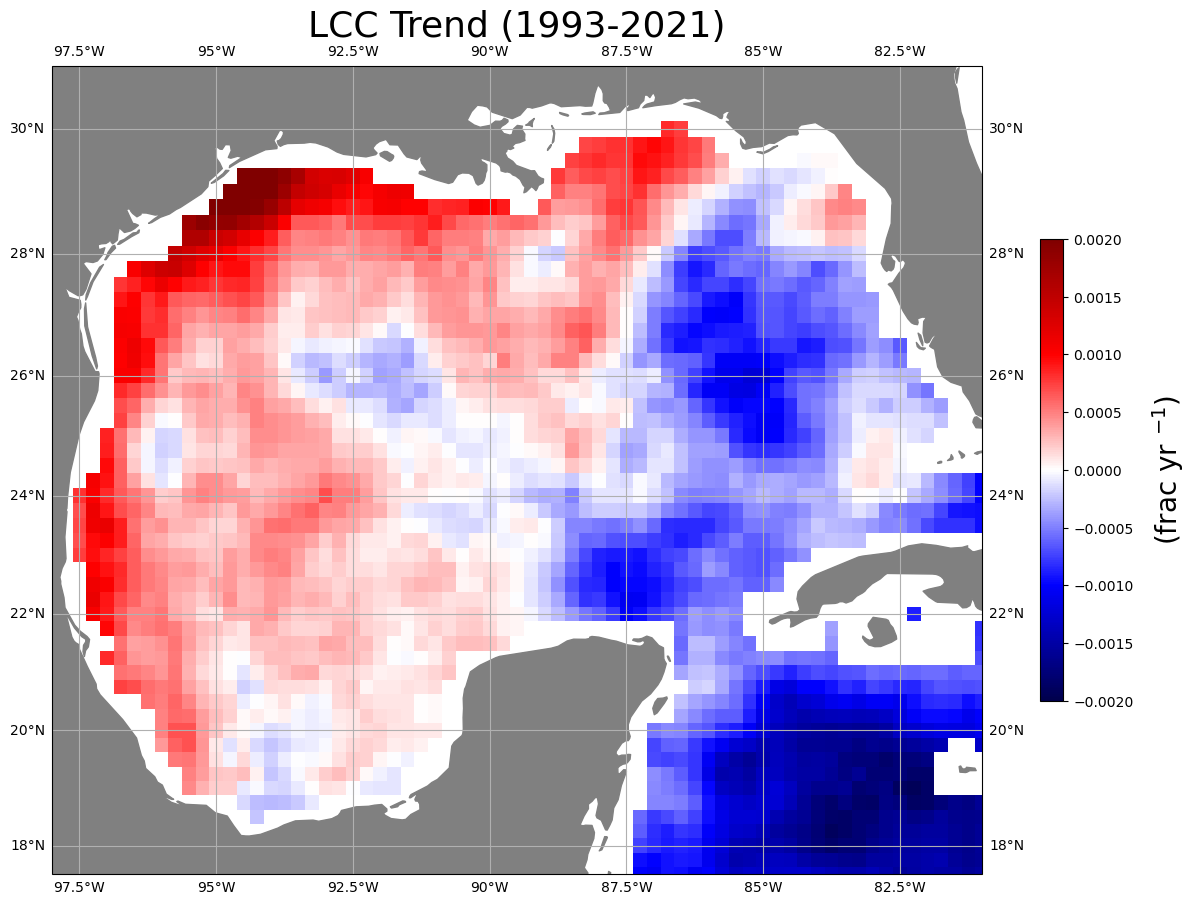

In [85]:
plot_trend(trend_lcc, 'LCC Trend (1993-2021)', 'LCC', '(frac yr $^{-1}$)', -0.002, 0.002, cmap_choice='seismic')

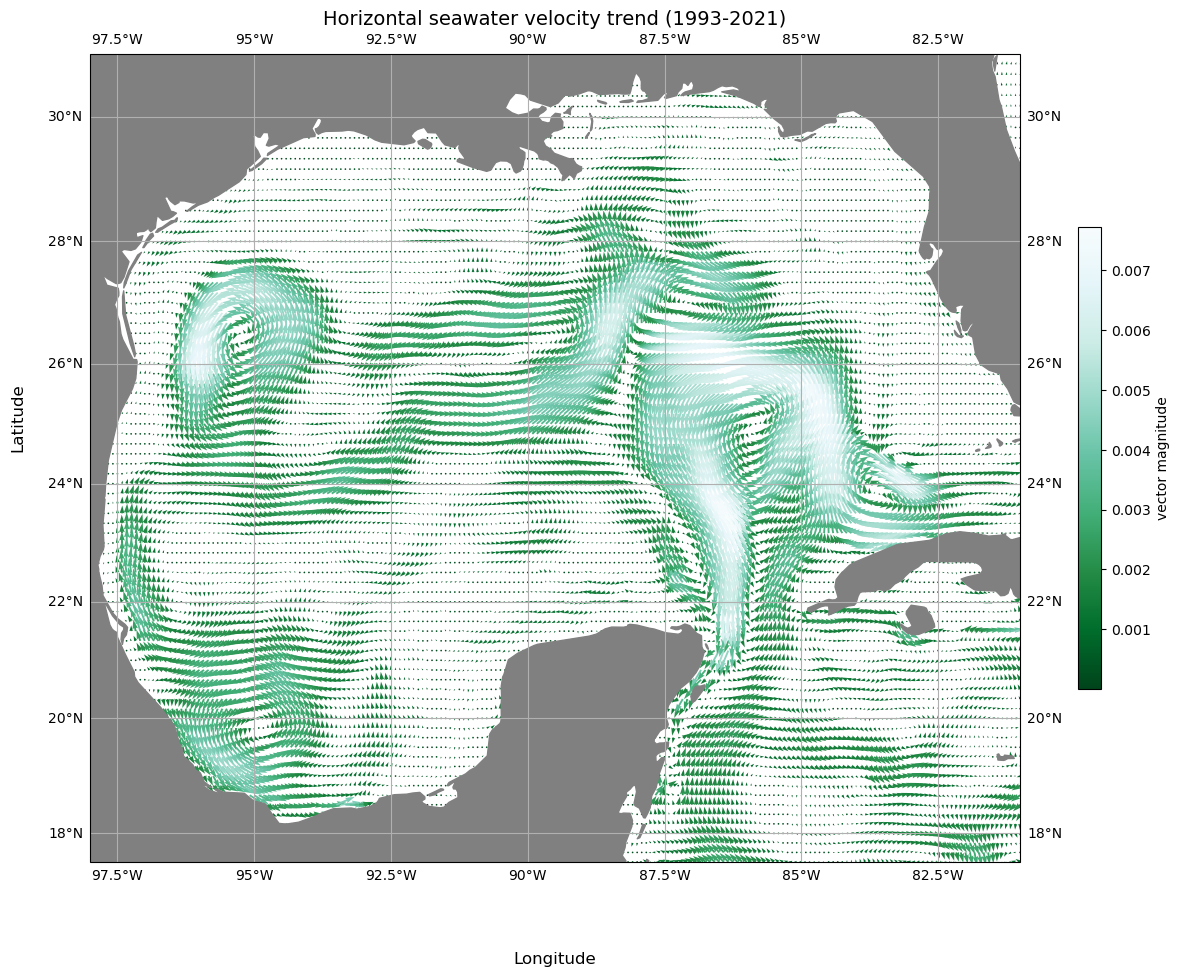

In [25]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
du = trend_u.polyfit_coefficients[0]
dv = trend_v.polyfit_coefficients[0]
#norm = TwoSlopeNorm(vmin=v_min, vcenter=0, vmax=v_max)
C = np.sqrt(du[::2]**2 + dv[::2]**2) # Magnitude of the vectors for coloring
im = ax.quiver(du[::2].longitude, du[::2].latitude, du[::2].values, dv[::2].values, C, width=0.002, scale=0.2,
               transform=ccrs.PlateCarree(), cmap='BuGn_r')
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("vector magnitude")

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Horizontal seawater velocity trend (1993-2021)', fontsize=14)
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/horiz_vel_trend.pdf');

In [25]:
print('Max: ', trend_u10.polyfit_coefficients[0].max().values, 'm/s/yr', 
      '\nMin: ', trend_u10.polyfit_coefficients[0].min().values, 'm/s/yr')

Max:  0.01145737958071838 m/s/yr 
Min:  -0.021471307665256012 m/s/yr


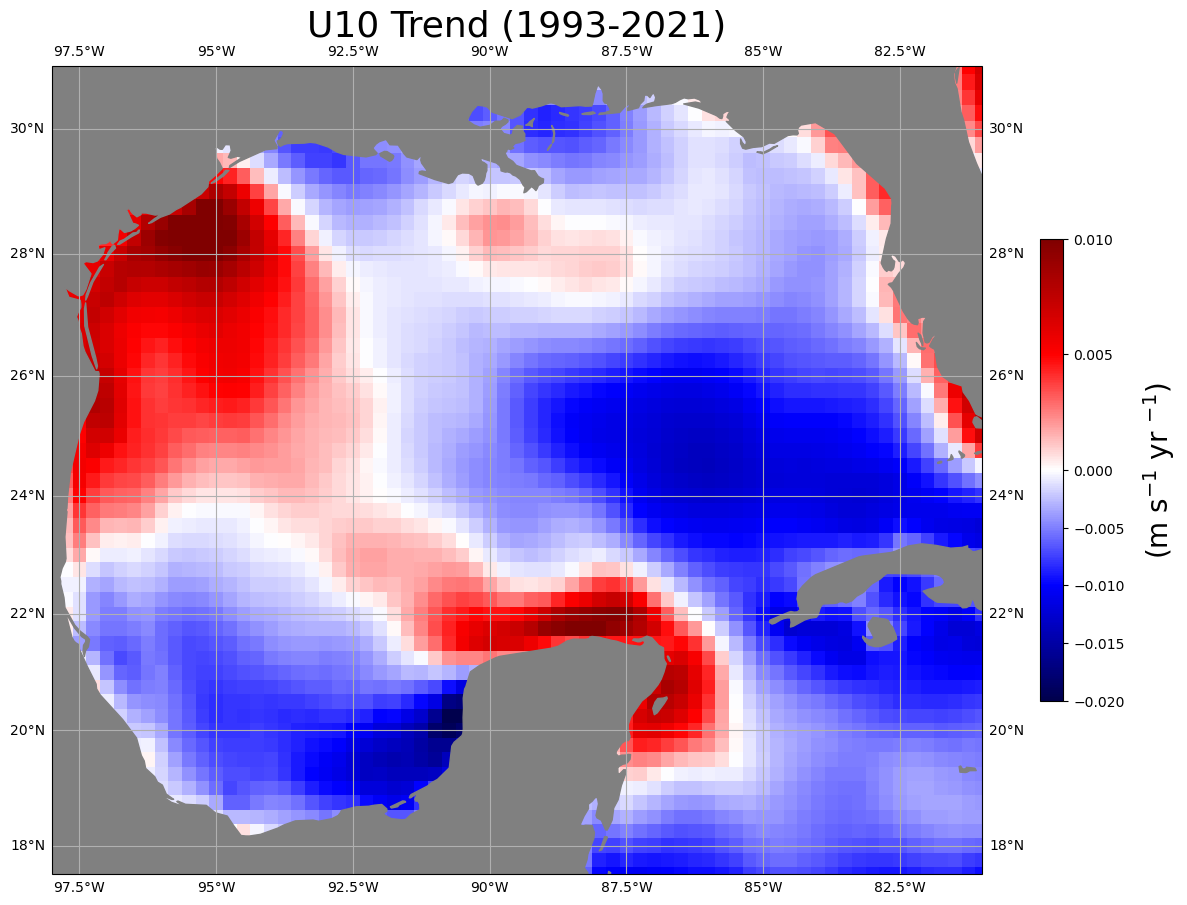

In [86]:
plot_trend(trend_u10, 'U10 Trend (1993-2021)', 'U10', '(m s$^{-1}$ yr $^{-1}$)', -0.02, 0.01, cmap_choice='seismic')

In [27]:
print('Max: ', trend_v10.polyfit_coefficients[0].max().values, 'm/s/yr', 
      '\nMin: ', trend_v10.polyfit_coefficients[0].min().values, 'm/s/yr')

Max:  0.017991427923070822 m/s/yr 
Min:  -0.007464926631139184 m/s/yr


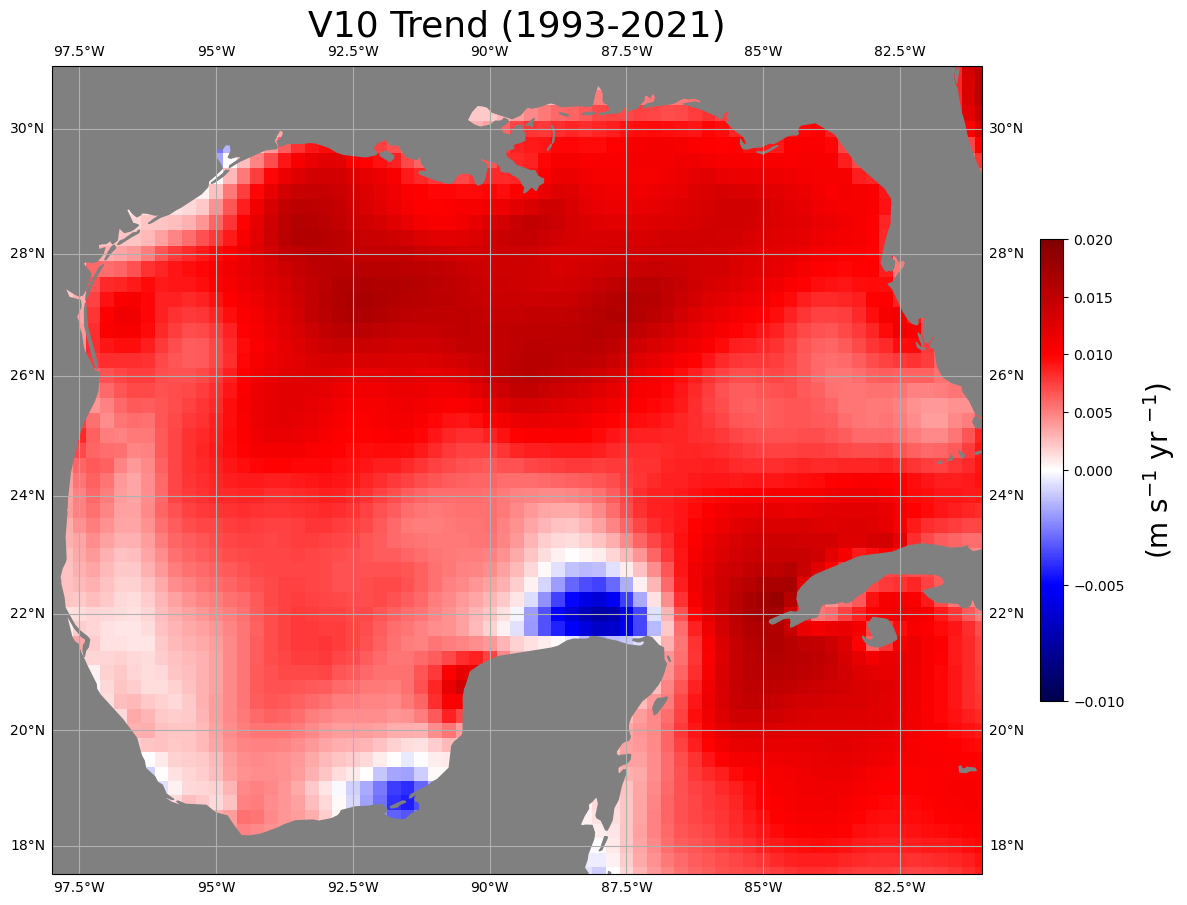

In [87]:
plot_trend(trend_v10, 'V10 Trend (1993-2021)', 'V10', '(m s$^{-1}$ yr $^{-1}$)', -0.01, 0.02, cmap_choice='seismic')

In [30]:
print('Max: ', trend_mslp.polyfit_coefficients[0].max().values, 'Pa/yr', 
      '\nMin: ', trend_mslp.polyfit_coefficients[0].min().values, 'Pa/yr')

Max:  2.5969866071434935 Pa/yr 
Min:  0.9614262623144919 Pa/yr


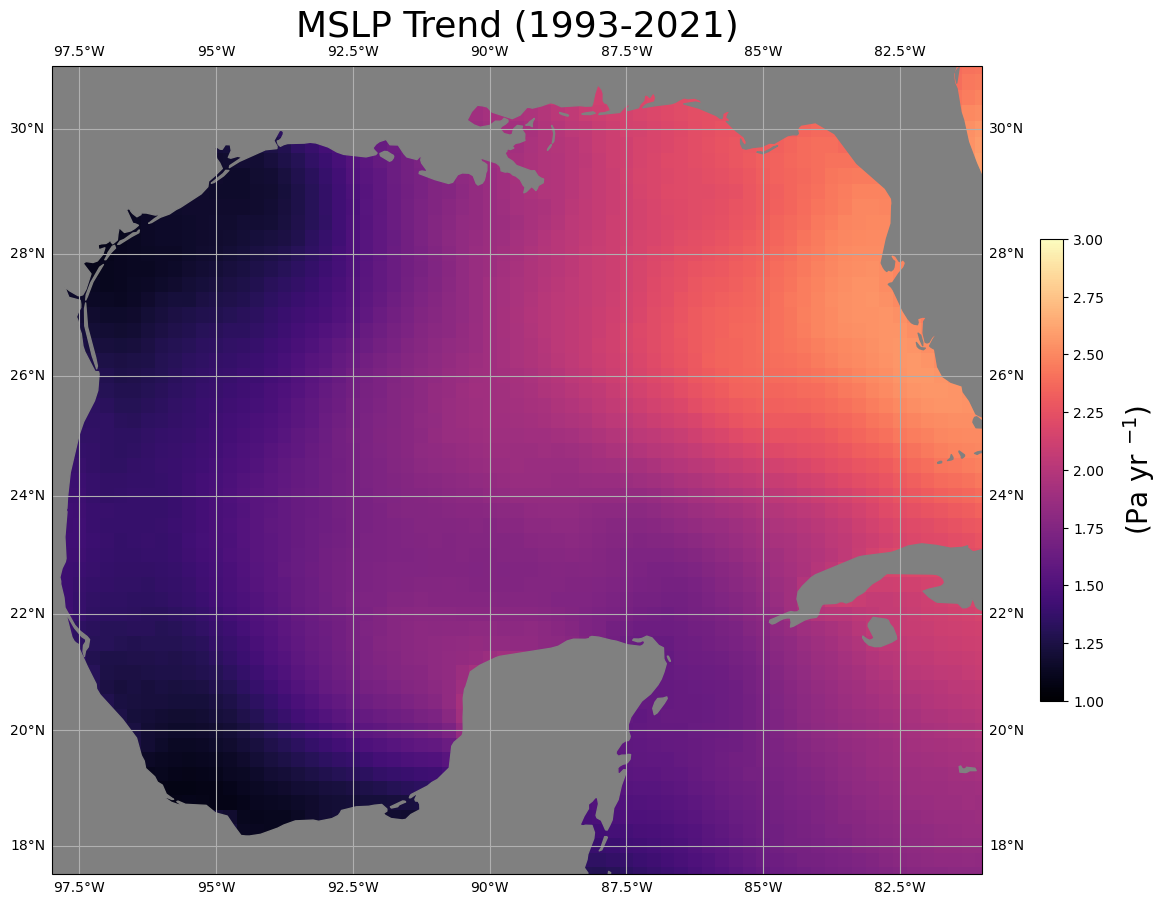

In [88]:
plot_trend(trend_mslp, 'MSLP Trend (1993-2021)', 'MSLP', '(Pa yr $^{-1}$)', 1,3, diverge=False, cmap_choice='magma')

In [16]:
print('Max: ', trend_sw.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_sw.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.31509241894097795 W/m2/yr 
Min:  -0.17060275656641974 W/m2/yr


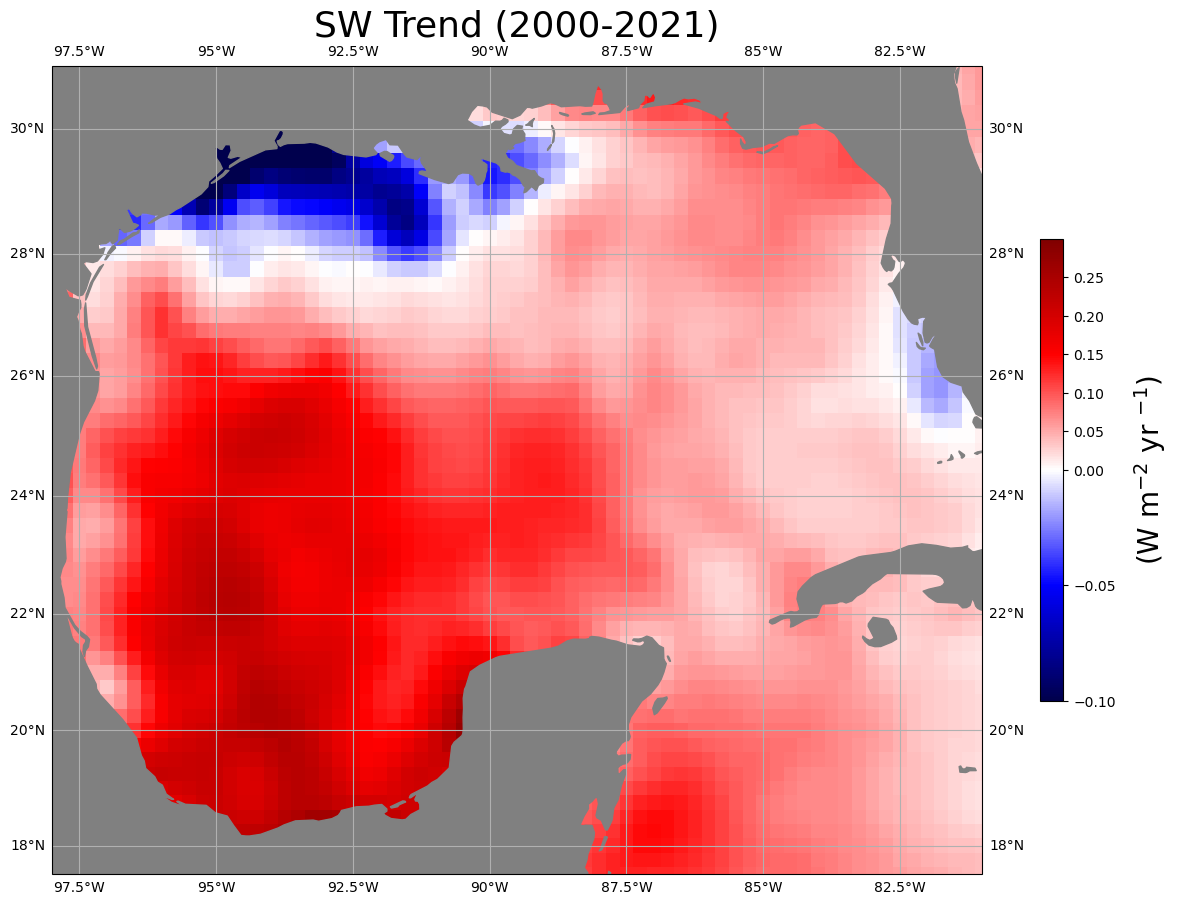

In [17]:
plot_trend(trend_sw, 'SW Trend (2000-2021)', 'SW', '(W m$^{-2}$ yr $^{-1}$)', -0.1, 0.3, cmap_choice='seismic')

In [18]:
print('Max: ', trend_lw.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_lw.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.48591428883247273 W/m2/yr 
Min:  -0.10786066419366523 W/m2/yr


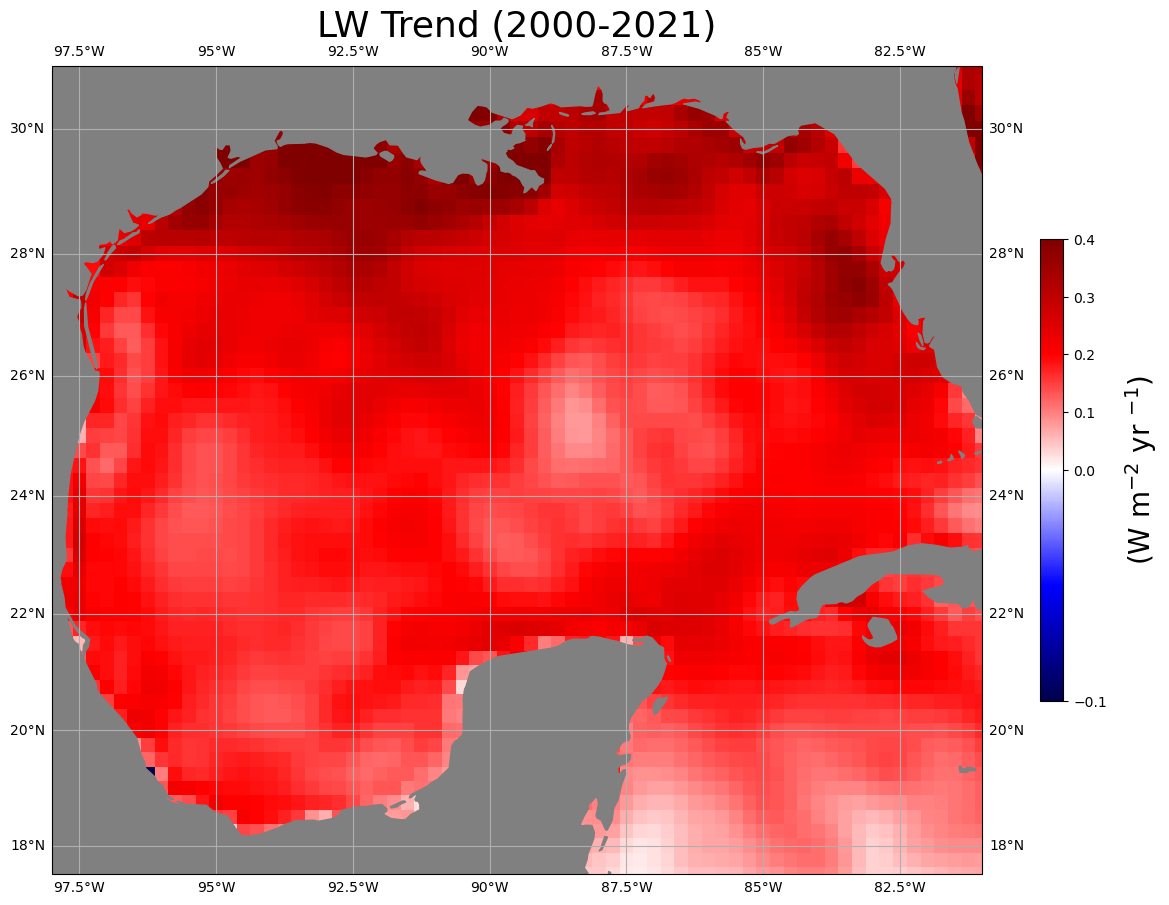

In [19]:
plot_trend(trend_lw, 'LW Trend (2000-2021)', 'LW', '(W m$^{-2}$ yr $^{-1}$)', -0.1, 0.4, cmap_choice='seismic')

In [52]:
print('Max: ', trend_lh.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_lh.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  1.0175485311513646 W/m2/yr 
Min:  -1.0396743852021677 W/m2/yr


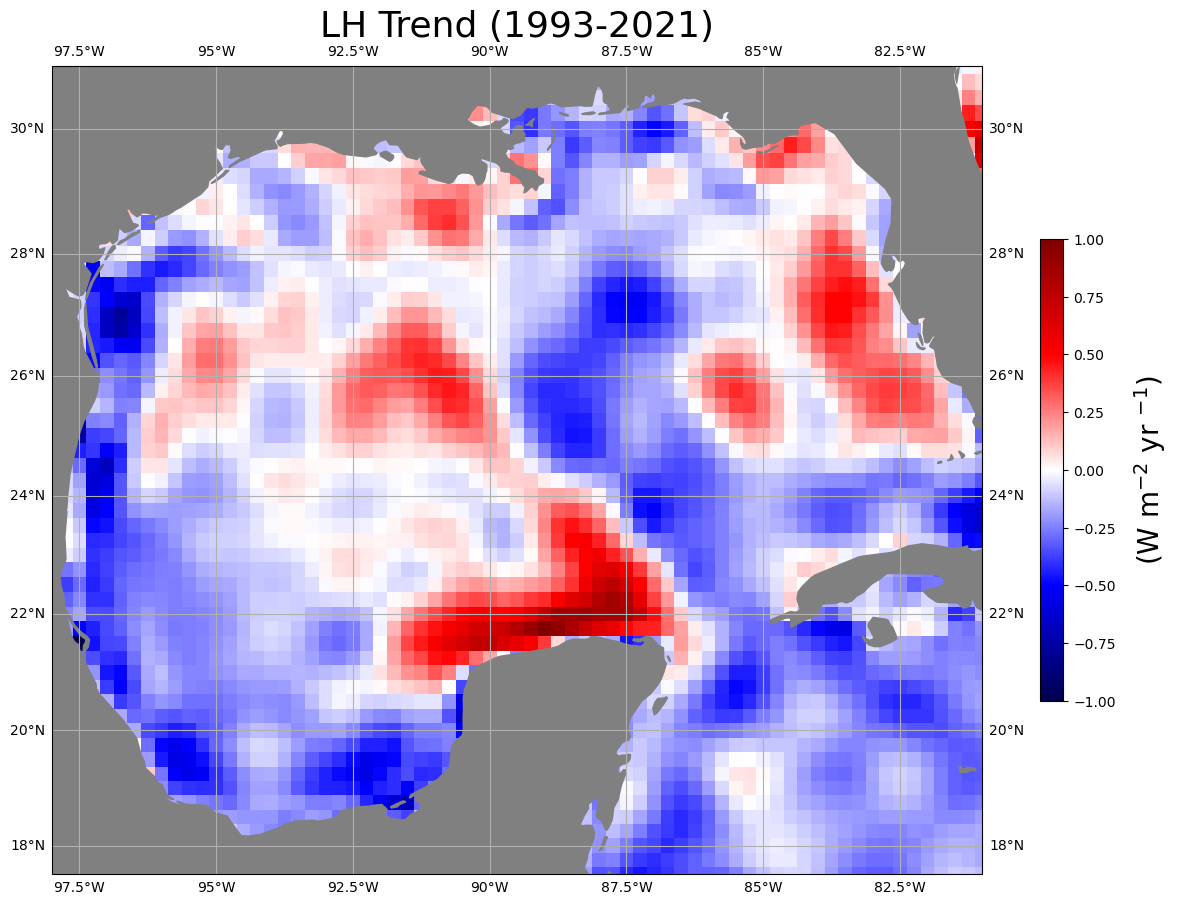

In [91]:
plot_trend(trend_lh, 'LH Trend (1993-2021)', 'LH', '(W m$^{-2}$ yr $^{-1}$)', -1, 1, cmap_choice='seismic')

In [54]:
print('Max: ', trend_sh.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_sh.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.7670891259812079 W/m2/yr 
Min:  -0.44202784551826113 W/m2/yr


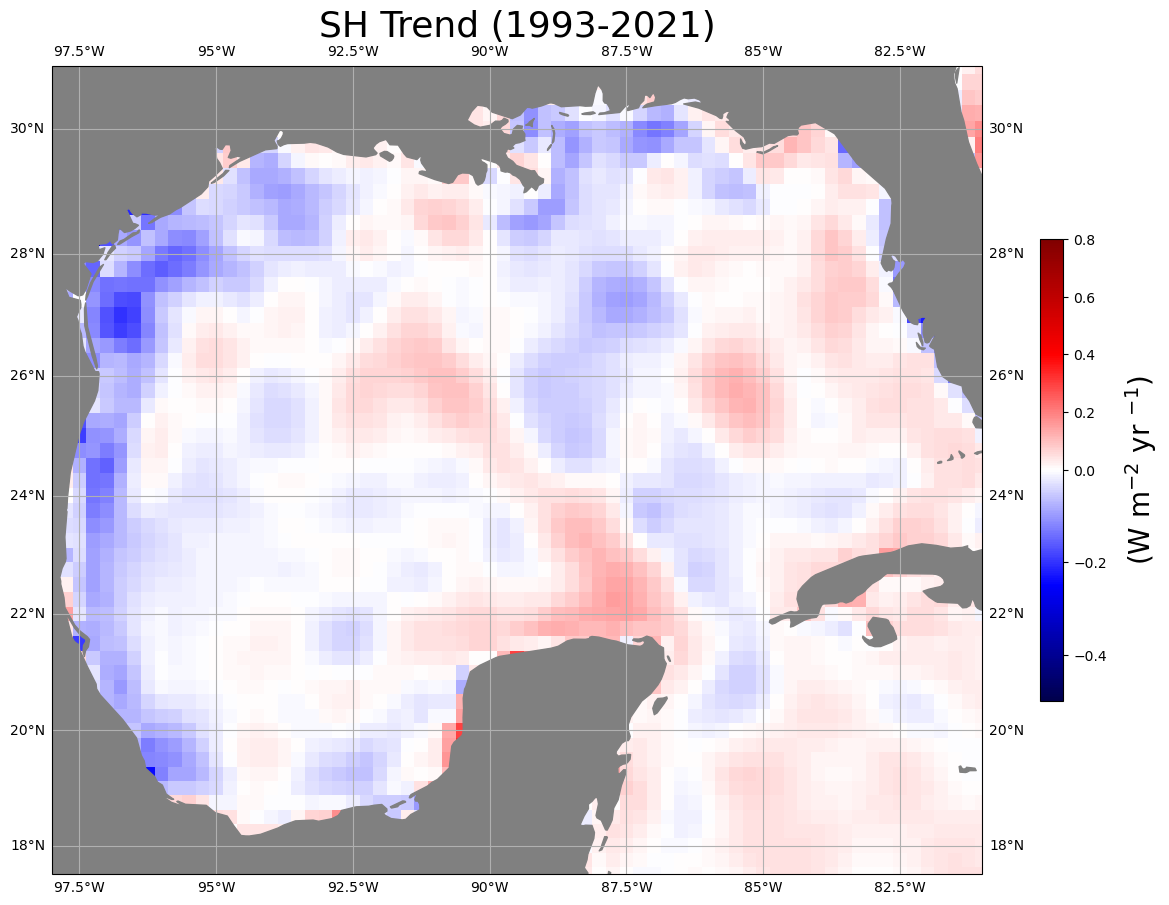

In [92]:
plot_trend(trend_sh, 'SH Trend (1993-2021)', 'SH', '(W m$^{-2}$ yr $^{-1}$)', -0.5, 0.8, cmap_choice='seismic')

In [56]:
print('Max: ', trend_sst_g.polyfit_coefficients[0].max().values, '˚C/yr', 
      '\nMin: ', trend_sst_g.polyfit_coefficients[0].min().values, '˚C/yr')

Max:  0.029032845992137648 ˚C/yr 
Min:  -0.0334678885237912 ˚C/yr


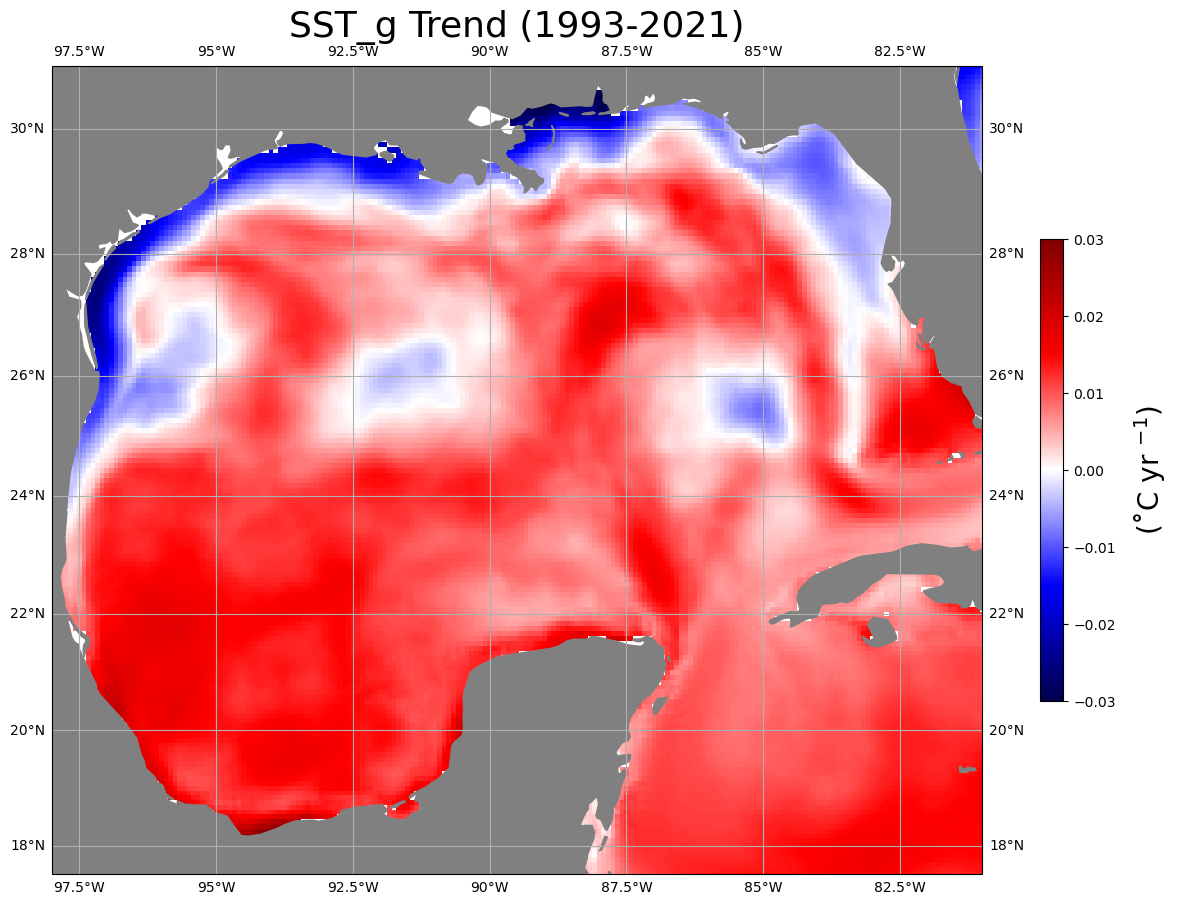

In [94]:
plot_trend(trend_sst_g, 'SST_g Trend (1993-2021)', 'SST_g', '(˚C yr $^{-1}$)', -0.03, 0.03, cmap_choice='seismic')

In [59]:
print('Max: ', trend_ssh.polyfit_coefficients[0].max().values, 'm/yr', 
      '\nMin: ', trend_ssh.polyfit_coefficients[0].min().values, 'm/yr')

Max:  0.006235263610535404 m/yr 
Min:  -0.0011776598752006326 m/yr


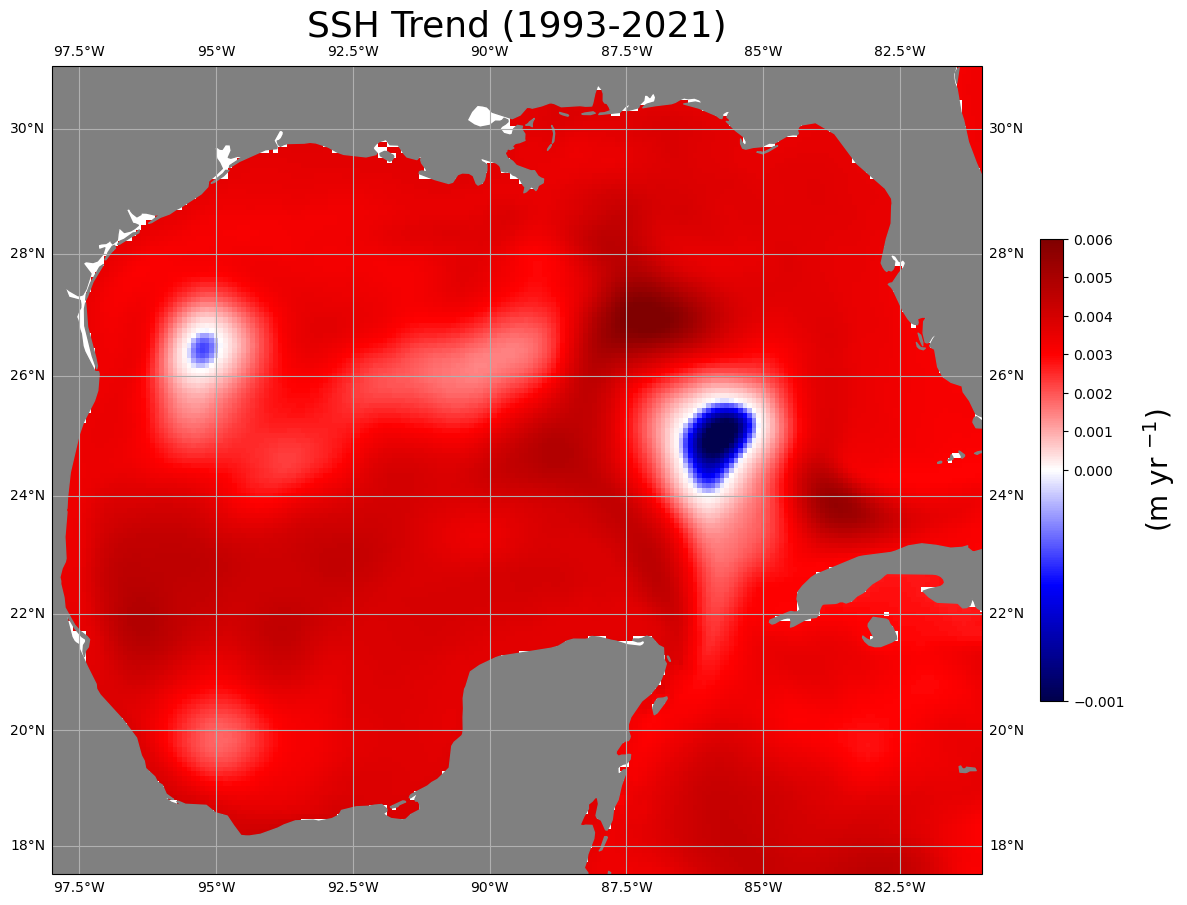

In [95]:
plot_trend(trend_ssh, 'SSH Trend (1993-2021)', 'SSH', '(m yr $^{-1}$)', -0.001, 0.006, cmap_choice='seismic')

In [62]:
print('Max: ', trend_u.polyfit_coefficients[0].max().values, 'm/s/yr', 
      '\nMin: ', trend_u.polyfit_coefficients[0].min().values, 'm/s/yr')

Max:  0.005944803935781214 m/s/yr 
Min:  -0.006900215880927309 m/s/yr


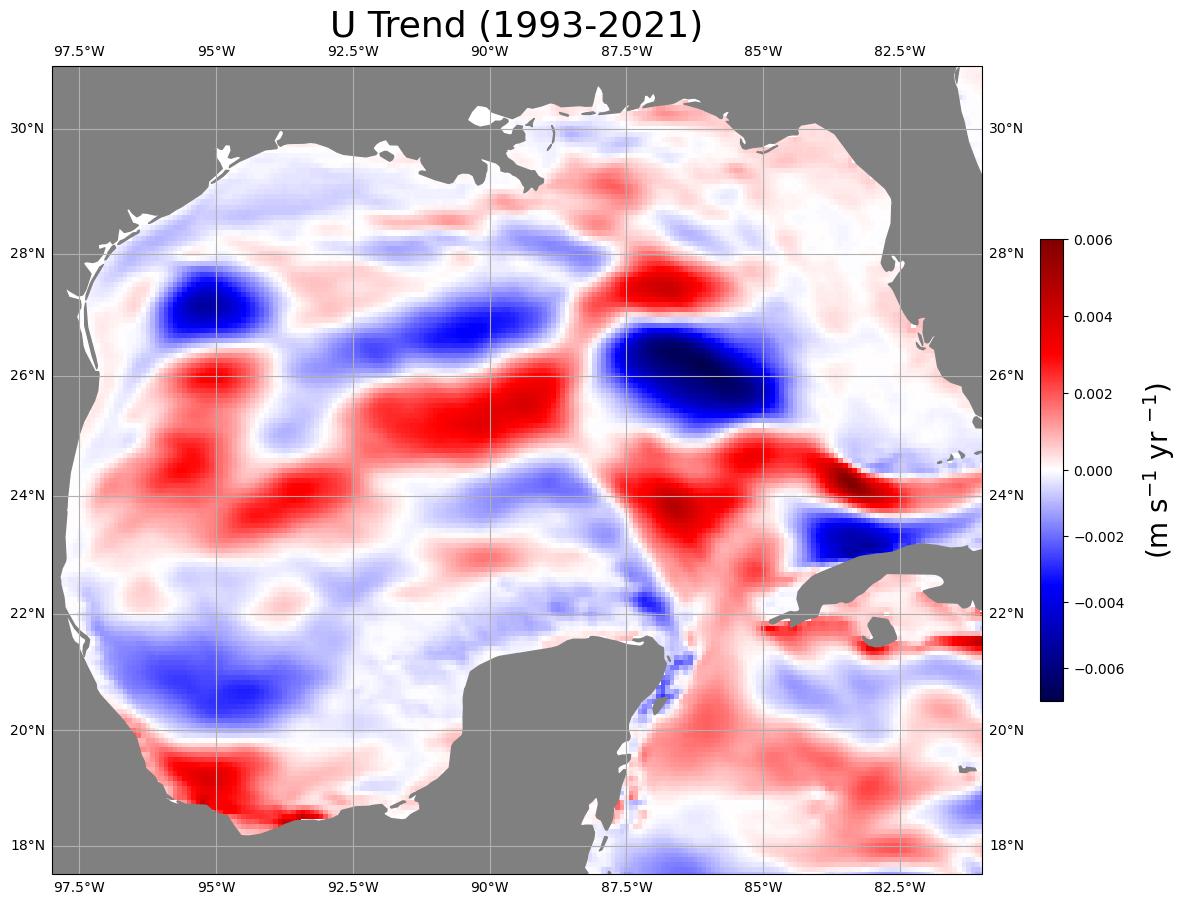

In [96]:
plot_trend(trend_u, 'U Trend (1993-2021)', 'U', '(m s$^{-1}$ yr $^{-1}$)', -0.007, 0.006, cmap_choice='seismic')

In [64]:
print('Max: ', trend_v.polyfit_coefficients[0].max().values, 'm/s/yr', 
      '\nMin: ', trend_v.polyfit_coefficients[0].min().values, 'm/s/yr')

Max:  0.007324029156864233 m/s/yr 
Min:  -0.0070908477964109285 m/s/yr


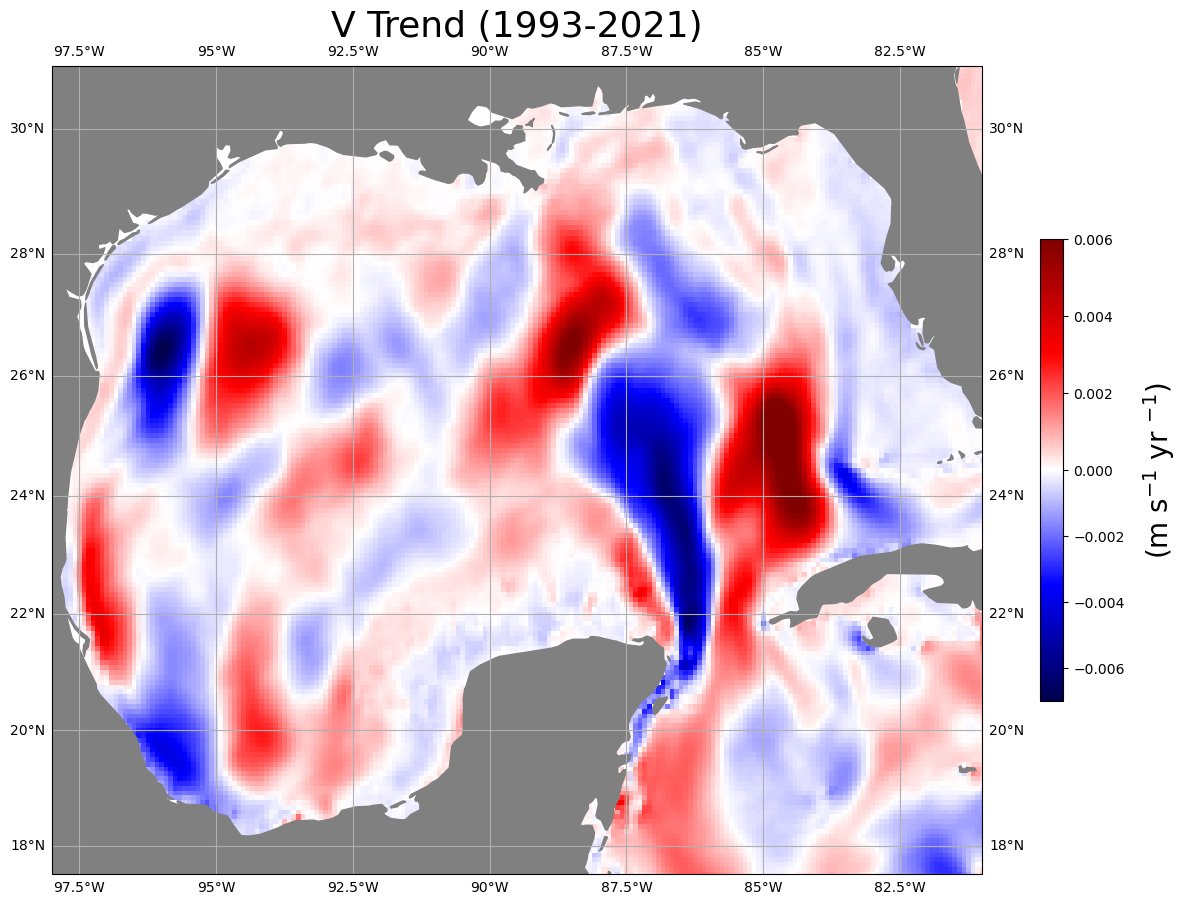

In [97]:
plot_trend(trend_v, 'V Trend (1993-2021)', 'V', '(m s$^{-1}$ yr $^{-1}$)', -0.007, 0.006, cmap_choice='seismic')

In [67]:
print('Max: ', trend_eke.polyfit_coefficients[0].max().values, 'm2/s2/yr', 
      '\nMin: ', trend_eke.polyfit_coefficients[0].min().values, 'm2/s2/yr')

Max:  0.004142131137567736 m2/s2/yr 
Min:  -0.005742467768644997 m2/s2/yr


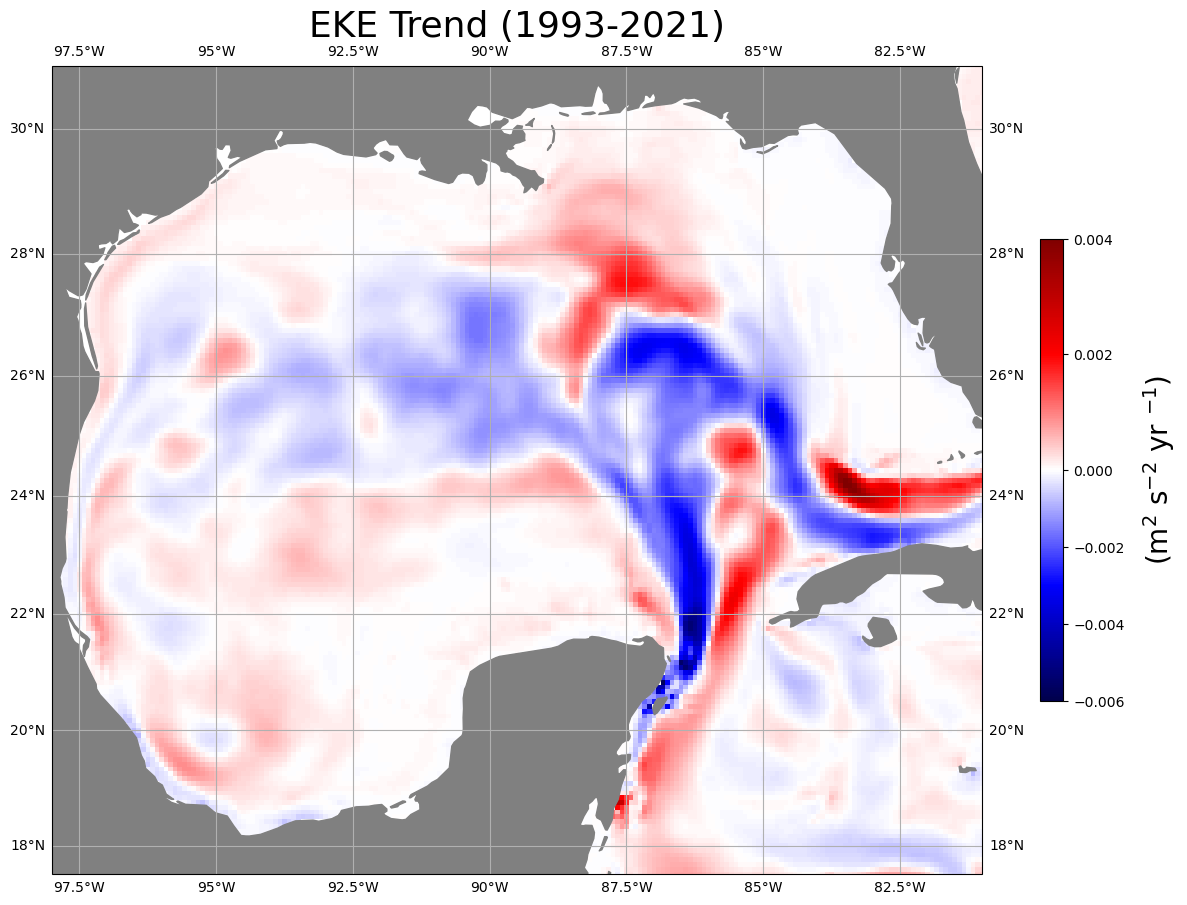

In [98]:
plot_trend(trend_eke, 'EKE Trend (1993-2021)', 'EKE', '(m$^{2}$ s$^{-2}$ yr $^{-1}$)', -0.006, 0.004, cmap_choice='seismic')

## Trends (basin-average)

#### Calculate trend lines

In [15]:
def trending(da):
    d = {}
    d['trend_lr'] = linregress(np.arange(0, da.time.size), da.mean(['latitude', 'longitude']))#.fillna(0.))
    d['trend_line_lr'] = (d['trend_lr'][0]*np.arange(0,da.time.size) + d['trend_lr'][1])

    return d

In [17]:
da_names = [sst, tcc, lcc, mslp, u10, v10, sw, lw, sh, lh, sst_g, ssh, u, v, eke, air_density, ef, tau] #[0:13]
#name_index 0     1     2    3    4    5    6   7   8   9   10    11  12 13, 14, 15, 16, 17
trend_list = list()
for i in da_names:
    trend_list.append(trending(i))

In [18]:
trend_list[0]['trend_line_lr']

array([26.16045261, 26.16045504, 26.16045747, ..., 26.76746001,
       26.76746244, 26.76746487])

In [19]:
trend_list[-1]['trend_lr']

LinregressResult(slope=np.float64(-1.5211825678418254e-09), intercept=np.float64(0.06715381606043606), rvalue=np.float64(-0.003306338864736065), pvalue=np.float64(0.09843718347706137), stderr=np.float64(9.205430001933198e-10), intercept_stderr=np.float64(0.00013275799167789738))

In [20]:
def plotting_trend_lines(da, trend_da, ylabel=None, var_title=None,):
    da.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='blue')
    plt.plot(da.time, trend_da, color='r', linestyle='dashed')
    plt.grid()
    plt.ylabel(ylabel)
    plt.xlim(da.time.sel(time='1993-01-01', method='nearest'), 
             da.time.sel(time='2021-06-30', method='nearest'))
    plt.title(fr'ERA5 spatially averaged {var_title} (1993-2021)')
    plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/trend_lines_{var_title}.pdf');

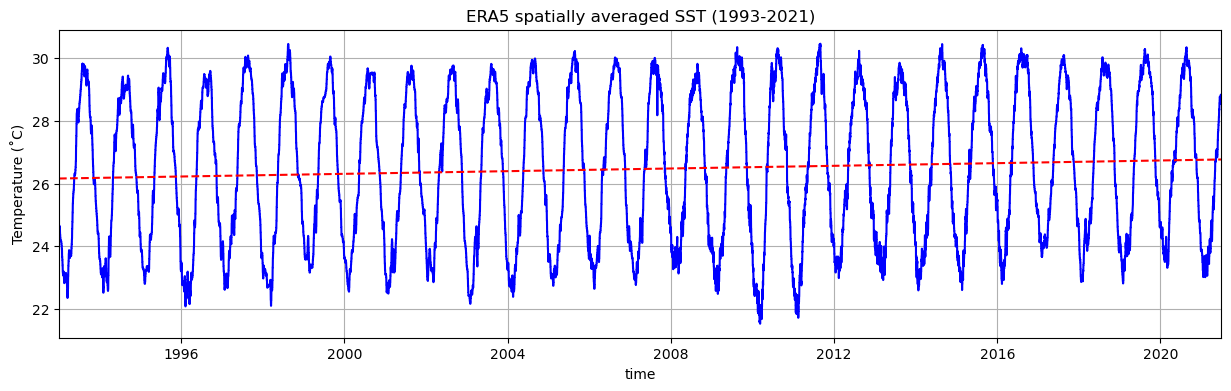

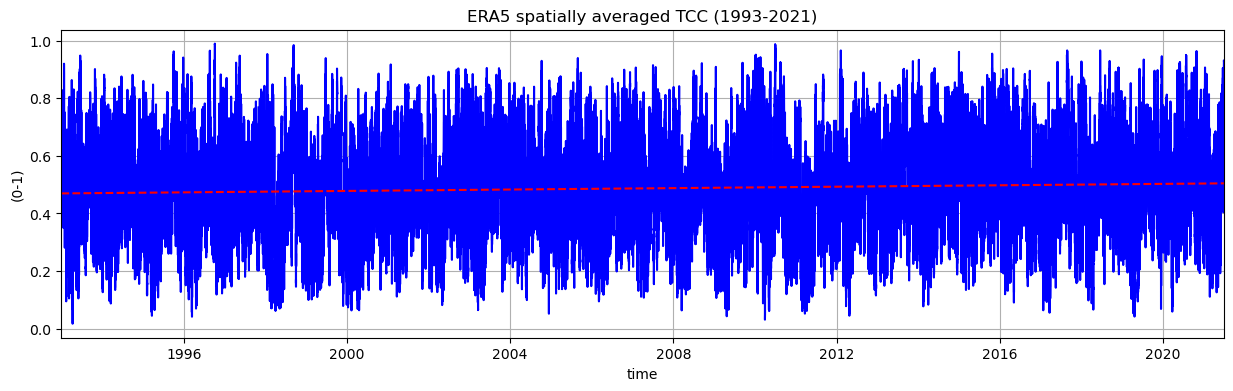

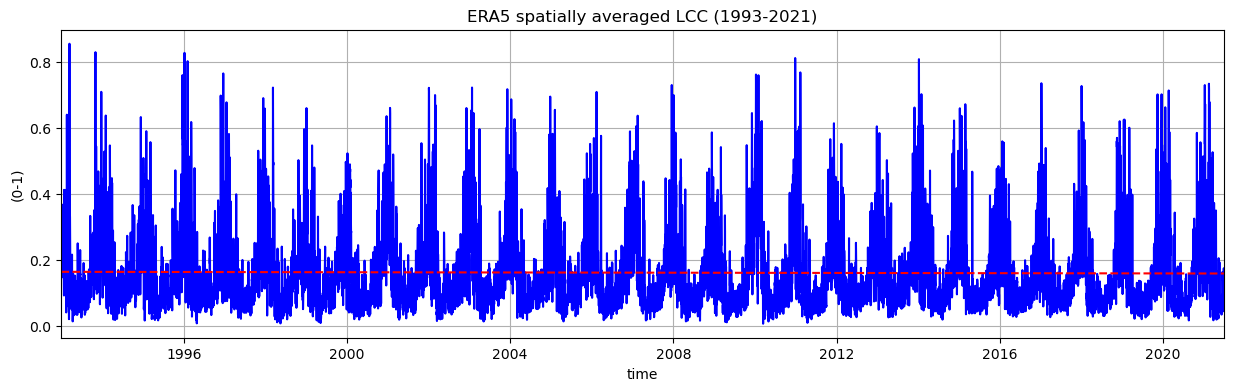

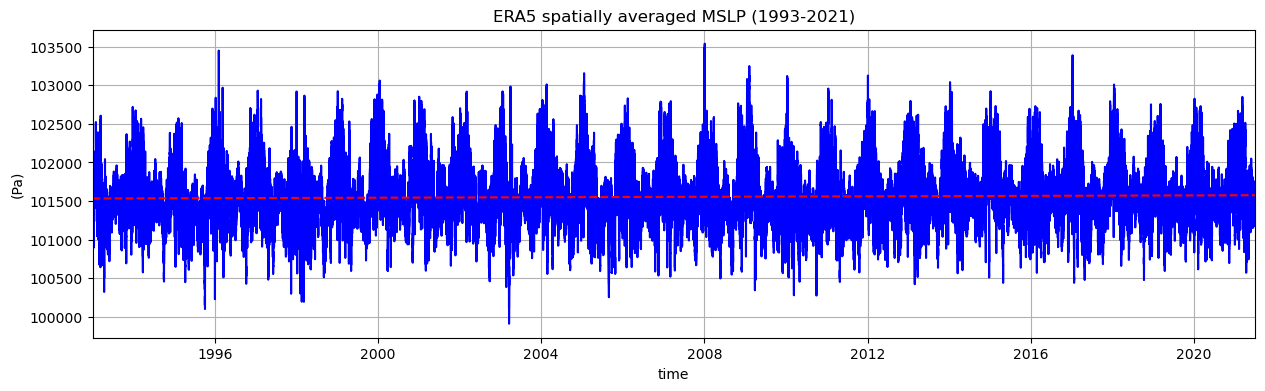

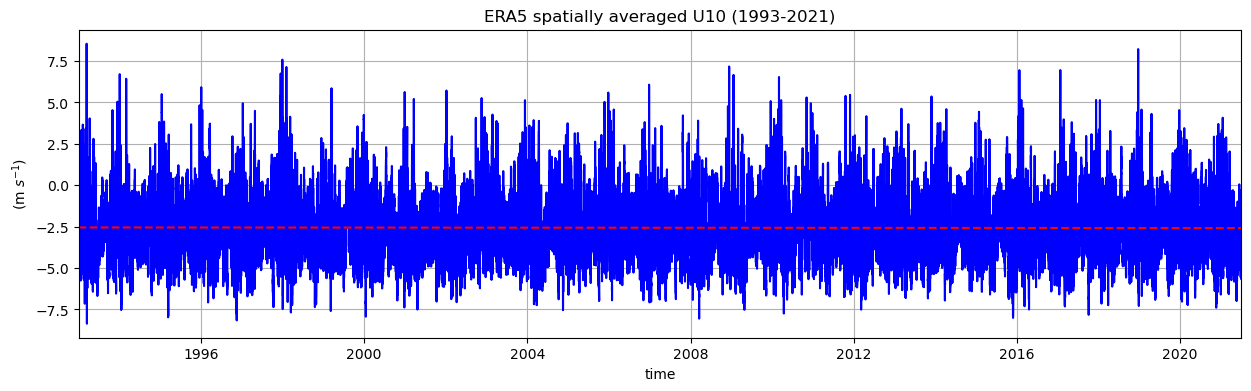

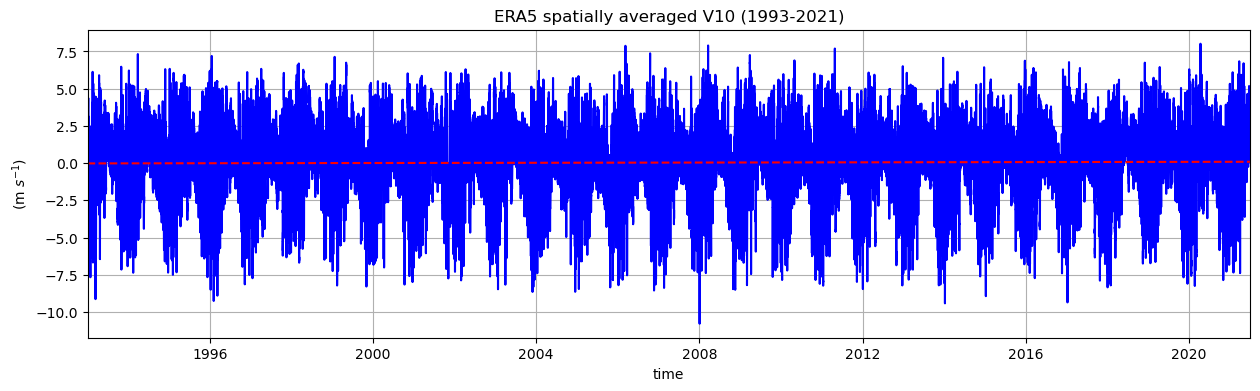

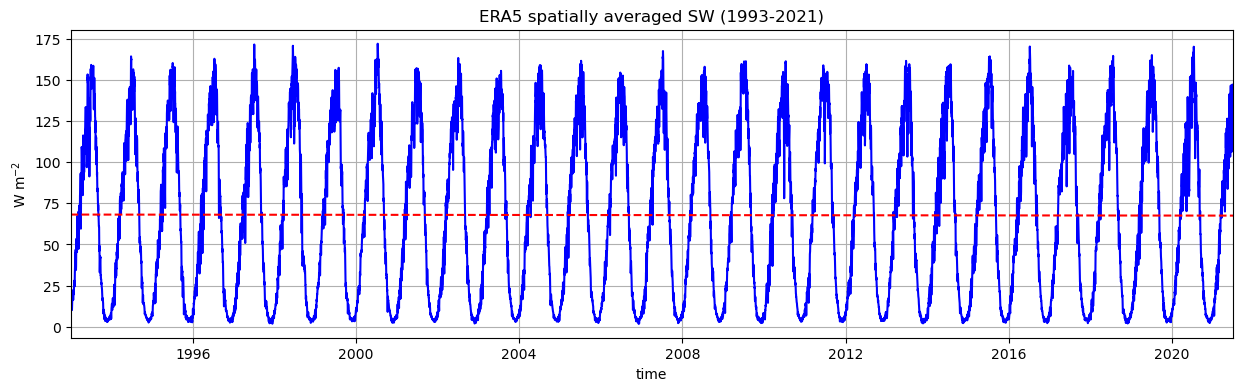

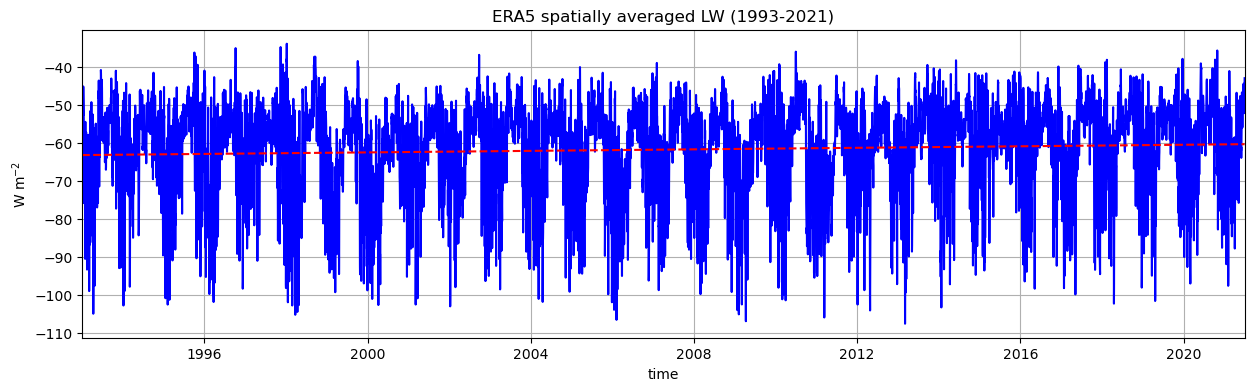

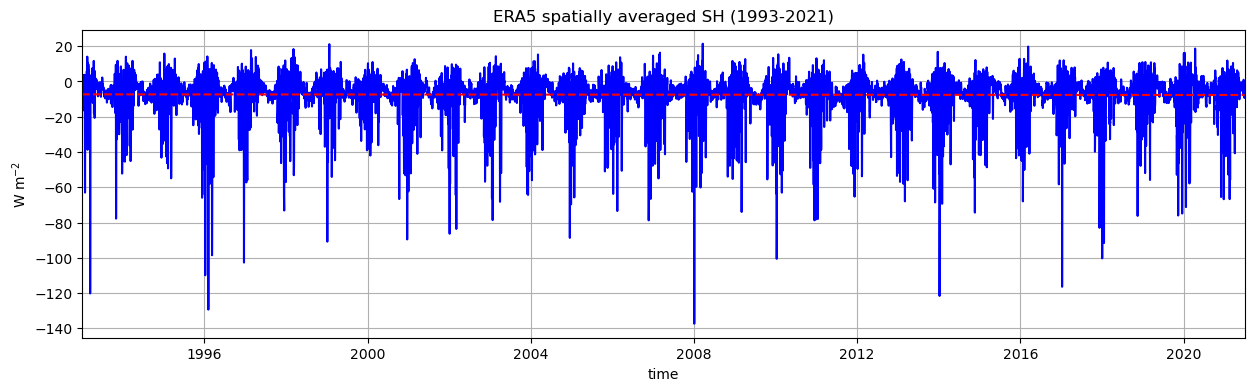

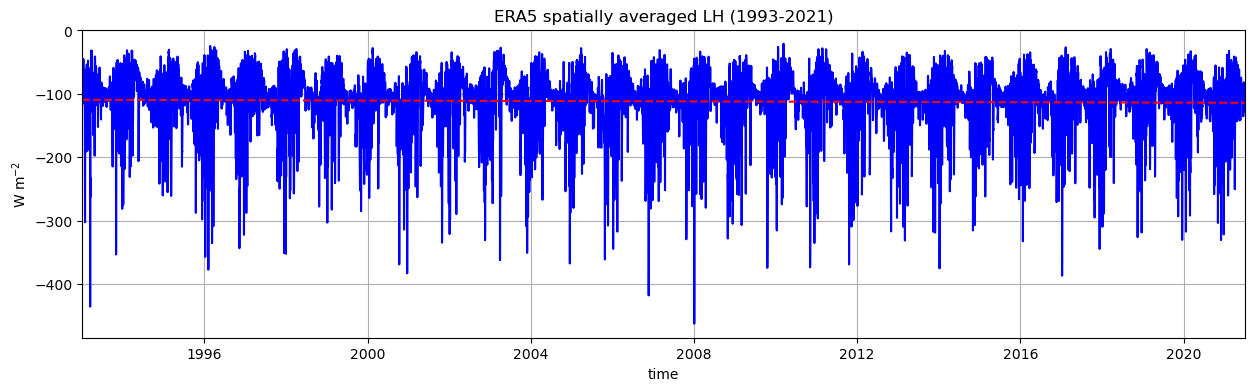

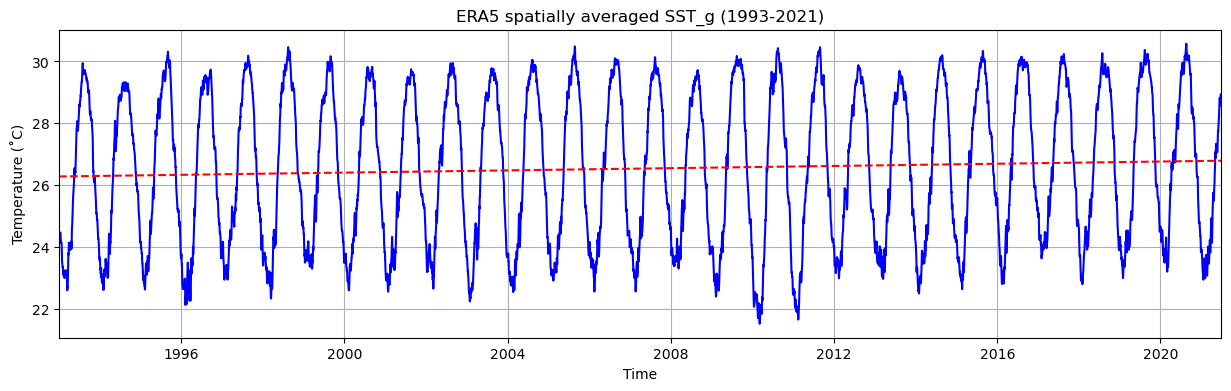

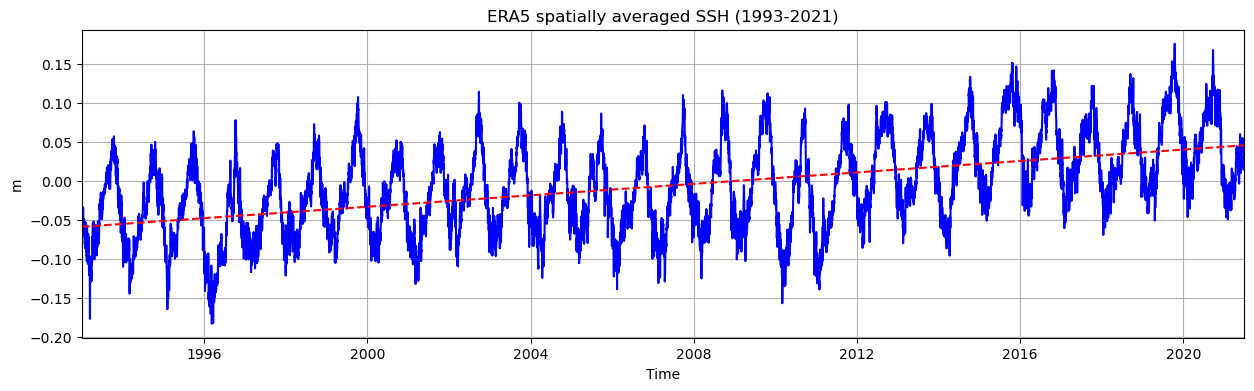

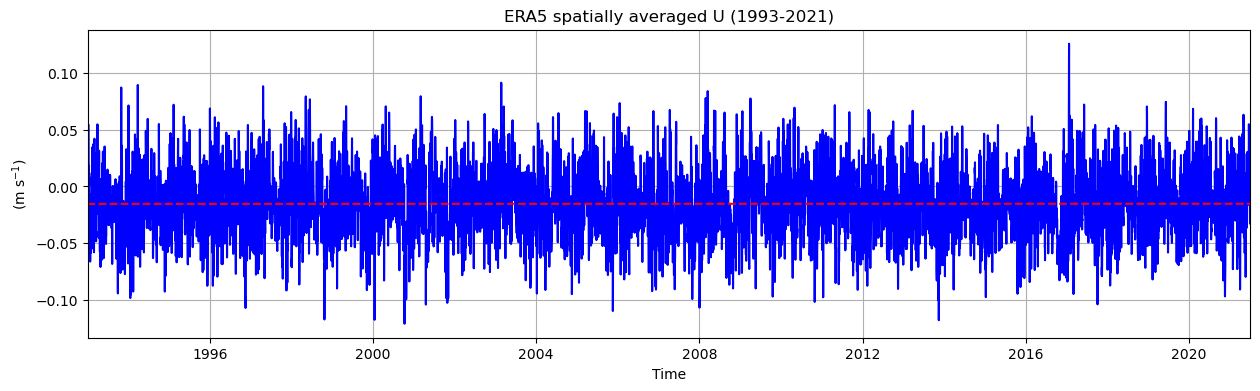

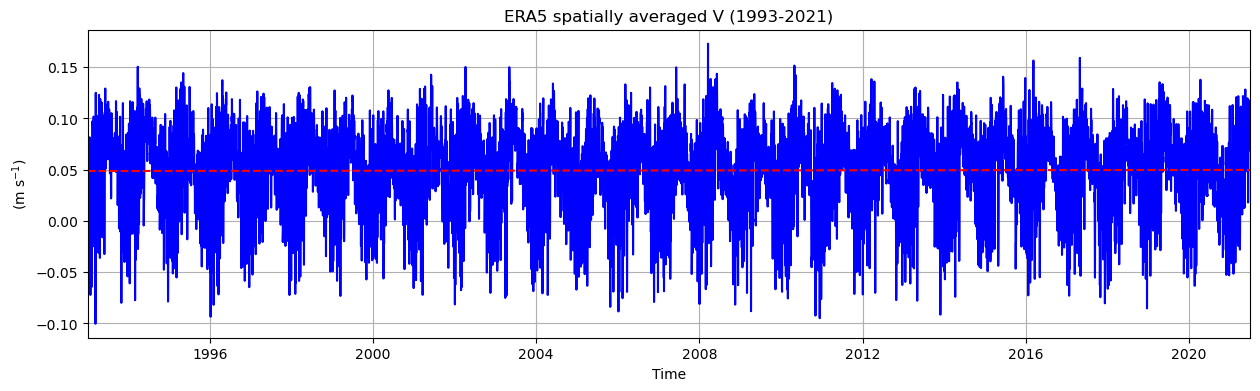

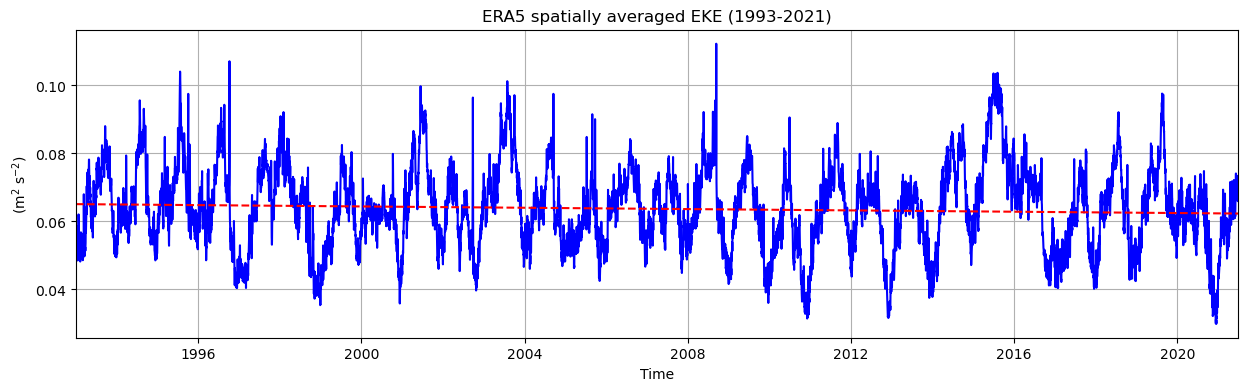

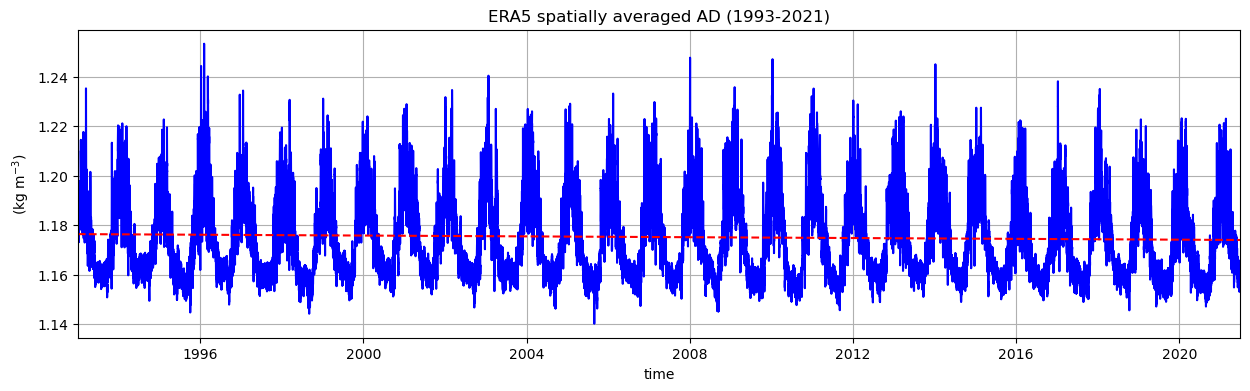

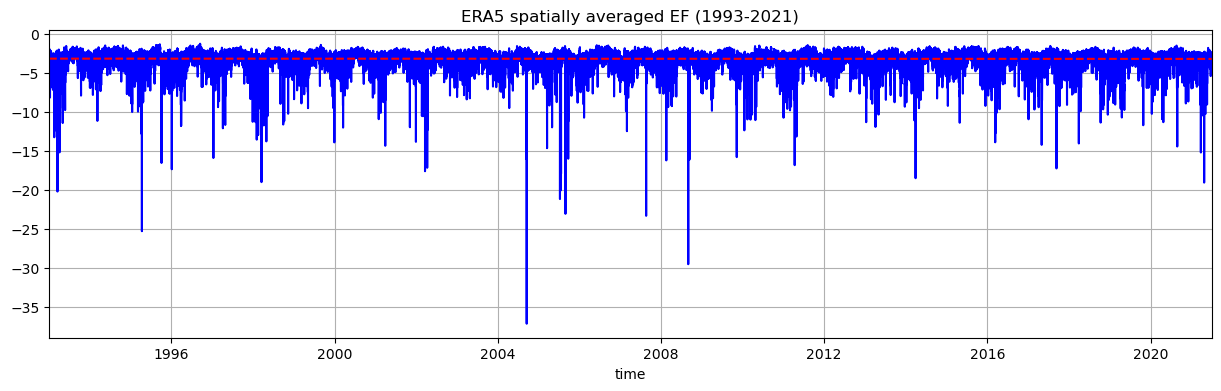

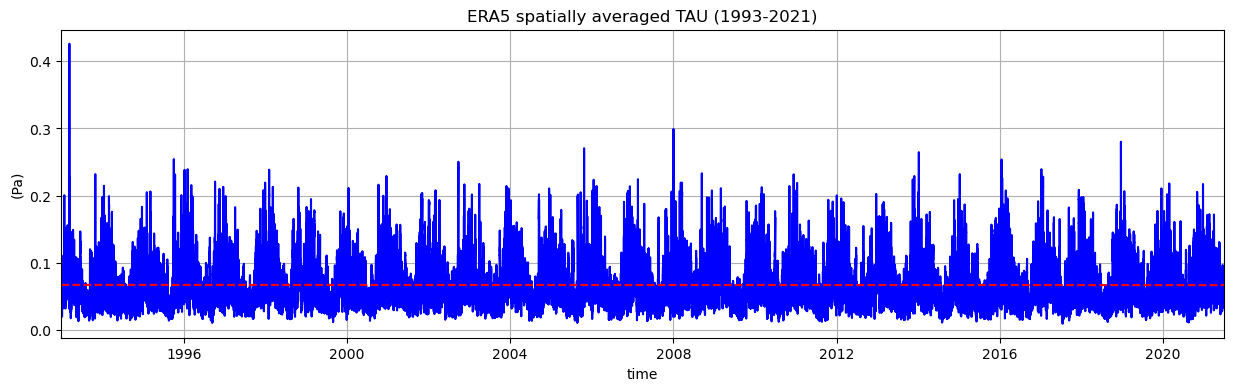

In [26]:
ylabels = ['Temperature (˚C)', '(0-1)', '(0-1)', '(Pa)', '(m $s^{-1}$)', '(m $s^{-1}$)',
           'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', 'Temperature (˚C)', 'm',
           '(m s$^{-1}$)', '(m s$^{-1}$)', '(m$^2$ s$^{-2}$)',
          '(kg m$^{-3}$)', '', '(Pa)']
var_titles = ['SST', 'TCC', 'LCC', 'MSLP', 'U10', 'V10', 
              'SW', 'LW', 'SH', 'LH', 'SST_g', 'SSH', 'U', 'V', 'EKE',
             'AD', 'EF', 'TAU']
for (i,j,k,l) in zip(da_names, np.arange(0,18), ylabels, var_titles):
    plotting_trend_lines(i, trend_list[j]['trend_line_lr'], k, l)

In [23]:
for i in np.arange(0,18):
    print(var_titles[i], 'slope ==', trend_list[i]['trend_lr'][0])

SST slope == 2.4300805680235704e-06
TCC slope == 1.3989916844970575e-07
LCC slope == -4.938460552953631e-07
MSLP slope == 0.0001706701654631276
U10 slope == -1.4776785004170133e-07
V10 slope == 4.401516818593187e-07
SW slope == -6.121409525188441e-05
LW slope == 0.0002753859479434253
SH slope == -3.4988257570768775e-05
LH slope == -0.0004521648328423791
SST_g slope == 4.893266328504842e-05
SSH slope == 1.0044641534809106e-05
U slope == 1.3465207947274719e-08
V slope == 1.0190260243027439e-07
EKE slope == -2.6572447562337703e-07
AD slope == -9.524028311124205e-09
EF slope == -1.2775255703410666e-07
TAU slope == -1.5211825678418254e-09


In [20]:
trend_list[0]['trend_lr'][0]

np.float64(2.4300805680235704e-06)

In [17]:
trend_list[-5]['trend_lr'][0]

np.float64(4.893266328504842e-05)

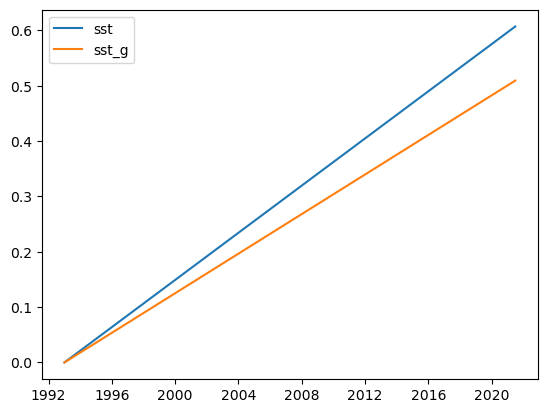

In [25]:
plt.plot(sst.time, trend_list[0]['trend_lr'][0]*np.arange(0,len(sst.time)), label='sst')
plt.plot(sst_g.time, trend_list[-8]['trend_lr'][0]*np.arange(0,len(sst_g.time)), label='sst_g')
plt.legend()

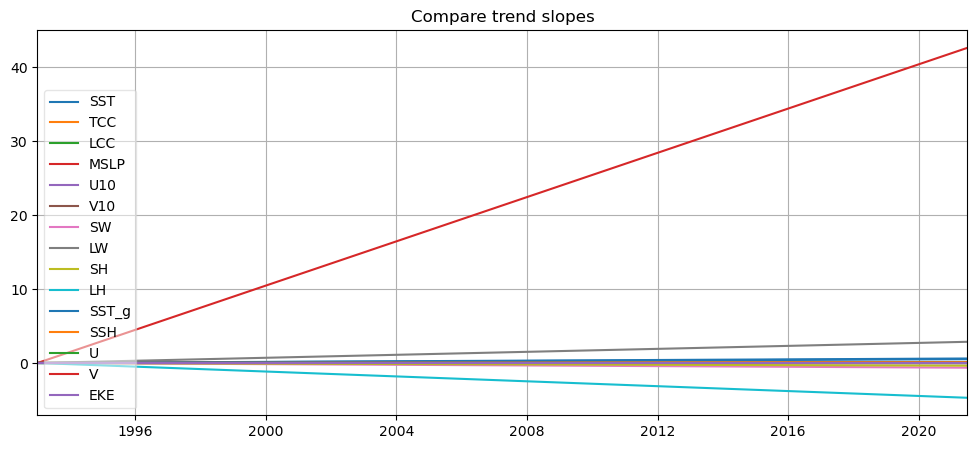

In [70]:
da_names = [sst, tcc, lcc, mslp, u10, v10, sw, lw, sh, lh, sst_g, ssh, u, v, eke] #[0:13]
var_titles = ['SST', 'TCC', 'LCC', 'MSLP', 'U10', 'V10', 
              'SW', 'LW', 'SH', 'LH', 'SST_g', 'SSH', 'U', 'V', 'EKE']
plt.figure(figsize=(12,5))
for i in np.arange(0,15):
    plt.plot(da_names[i].time, trend_list[i]['trend_lr'][0]*np.arange(0,len(da_names[i].time)), label=f'{var_titles[i]}')
plt.xlim(sst.time.sel(time='1993-01-01', method='nearest'), 
         sst.time.sel(time='2021-06-30', method='nearest'))
plt.legend()
plt.legend(loc='lower left', framealpha=0.5)
plt.grid()
plt.title('Compare trend slopes')
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/compare_trend_slopes.pdf')

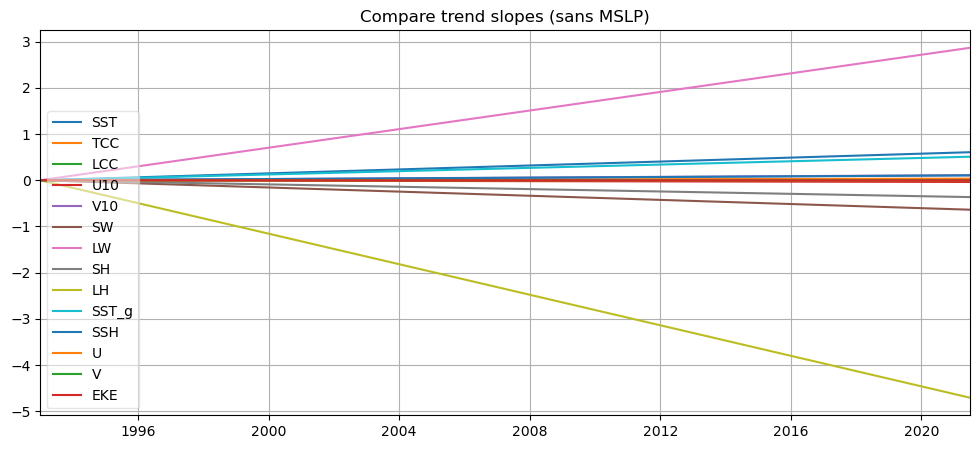

In [17]:
da_names = [sst, tcc, lcc, mslp, u10, v10, sw, lw, sh, lh, sst_g, ssh, u, v, eke] #[0:13]
var_titles = ['SST', 'TCC', 'LCC', 'MSLP', 'U10', 'V10', 
              'SW', 'LW', 'SH', 'LH', 'SST_g', 'SSH', 'U', 'V', 'EKE']
plt.figure(figsize=(12,5))
for i in np.arange(0,15):
    if i == 3:
        continue  
    plt.plot(da_names[i].time, trend_list[i]['trend_lr'][0]*np.arange(0,len(da_names[i].time)), label=f'{var_titles[i]}')
plt.xlim(sst.time.sel(time='1993-01-01', method='nearest'), 
         sst.time.sel(time='2021-06-30', method='nearest'))
plt.legend(loc='lower left', framealpha=0.5)
plt.grid()
plt.title('Compare trend slopes (sans MSLP)')
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/compare_trend_slopes_noMSLP.pdf')

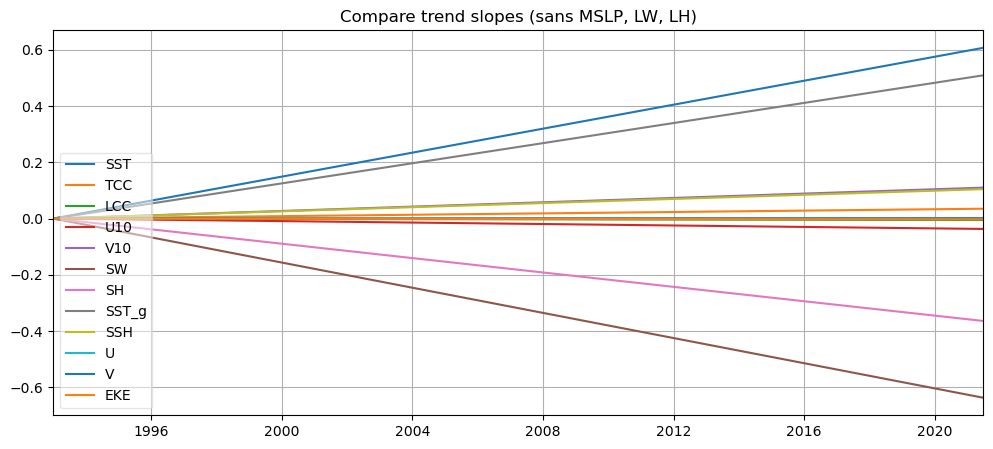

In [18]:
da_names = [sst, tcc, lcc, mslp, u10, v10, sw, lw, sh, lh, sst_g, ssh, u, v, eke] #[0:13]
var_titles = ['SST', 'TCC', 'LCC', 'MSLP', 'U10', 'V10', 
              'SW', 'LW', 'SH', 'LH', 'SST_g', 'SSH', 'U', 'V', 'EKE']
plt.figure(figsize=(12,5))
for i in np.arange(0,15):
    if i in [3, 7, 9]:
        continue  
    plt.plot(da_names[i].time, trend_list[i]['trend_lr'][0]*np.arange(0,len(da_names[i].time)), label=f'{var_titles[i]}')
plt.xlim(sst.time.sel(time='1993-01-01', method='nearest'), 
         sst.time.sel(time='2021-06-30', method='nearest'))
plt.legend(loc='lower left', framealpha=0.5)
plt.grid()
plt.title('Compare trend slopes (sans MSLP, LW, LH)')
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/compare_trend_slopes_noMSLP-LW-LH.pdf')

## EOF composites

### Load in data for EOFs

In [8]:
#ssh,eke,u,v,sst_g are from GLORYS

sst = xr.open_dataarray('/work5/stb/ERA5/anom-fields/sst_anom.nc', chunks={})
tcc = xr.open_dataarray('/work5/stb/ERA5/anom-fields/tcc_anom.nc', chunks={})
mslp = xr.open_dataarray('/work5/stb/ERA5/anom-fields/mslp_anom.nc', chunks={})
u10 = xr.open_dataarray('/work5/stb/ERA5/anom-fields/u10_anom.nc', chunks={})
v10 = xr.open_dataarray('/work5/stb/ERA5/anom-fields/v10_anom.nc', chunks={})
mask = xr.open_dataarray('/work5/stb/ERA5/mask.nc', chunks={})
lcc = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/lcc_anom.nc', chunks={})

sw = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/sw_anom.nc', chunks={})
lw = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/lw_anom.nc', chunks={})
sh = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/sh_anom.nc', chunks={})
lh = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/lh_anom.nc', chunks={})

ssh = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/ssh_anom.nc', chunks={})
u = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/u_anom.nc', chunks={})
v = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/v_anom.nc', chunks={})
eke = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/eke_anom.nc', chunks={})
sst_g = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/sst_g_anom.nc', chunks={})

In [9]:
def open_ds(filename):
    ds = xr.open_mfdataset(f'/work5/stb/MHW-gfdl/eofs/anom/{filename}_anom_*_9321.nc', chunks={})
    return ds

In [10]:
sst_eof = open_ds('sst')
tcc_eof = open_ds('tcc')
mslp_eof = open_ds('mslp')
u10_eof = open_ds('u10')
v10_eof = open_ds('v10')
lcc_eof = open_ds('lcc')

sw_eof = open_ds('sw')
lw_eof = open_ds('lw')
sh_eof = open_ds('sh')
lh_eof = open_ds('lh')

sst_g_eof = open_ds('sst_g')
ssh_eof = open_ds('ssh')
u_eof = open_ds('u')
v_eof = open_ds('v')
eke_eof = open_ds('eke')

## Calculate regression and plot

### Q FOR JOE: my data arrays are already nomalous (`b` in the regression func), do I still need `b = da_b - ...`

In [5]:
def regression(da_a, da_b, dims='time', source='era'):
    """Code borrowed from Joe Clark"""
    a = (da_a - da_a.mean(dim=dims)) / da_a.std()
    #a = (sst_eof.scores[mode] - sst_eof.scores[mode].mean(dim=dims)) / sst_eof.scores[mode].std()
    b = da_b - da_b.mean(dim=dims)#arrays are already anom so no need for this line

    if source=='era':
        C = (a.where(mask==0) * b.where(mask==0)).sum(dim=dims) / (a.where(mask==0)**2).sum(dim=dims)
    else:
        C = (a.where(mask==0) * b.where(~mask_g)).sum(dim=dims) / (a.where(mask==0)**2).sum(dim=dims)
    return C

/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/hom

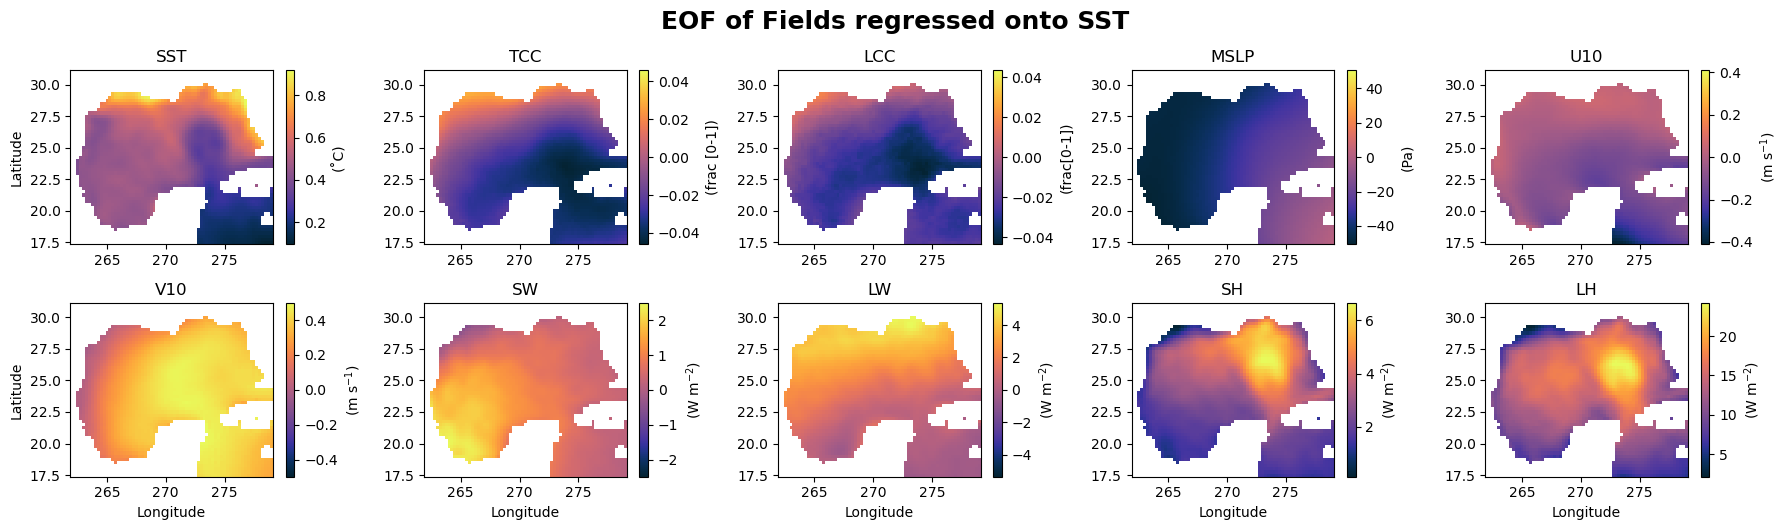

In [6]:
#regression of ERA5 fields on era5 sst_eof

#fields = [tcc_eof, lcc_eof, mslp_eof, u10_eof, v10_eof, sw_eof, lw_eof, 
#          sh_eof, lh_eof, ssh_eof, u_eof, v_eof, eke_eof]
fields = [sst, tcc, lcc, mslp, u10, v10, sw, lw, sh, lh]
var_titles = ['SST', 'TCC', 'LCC', 'MSLP', 'U10', 'V10', 
              'SW', 'LW', 'SH', 'LH']
units = ['(˚C)', '(frac [0-1])', '(frac[0-1])', '(Pa)', r'(m s$^{-1}$)', r'(m s$^{-1}$)',
         r'(W m$^{-2}$)', r'(W m$^{-2}$)', r'(W m$^{-2}$)', r'(W m$^{-2}$)']

fig, ax = plt.subplots(2,5, figsize=(18,5))
ax = ax.ravel()
for (i,j,k) in zip(fields, np.arange(0, len(fields)+1), units):
    #cmap_mask = plt.get_cmap("Greys")
    #mask.plot(cmap=cmap_mask, add_colorbar=False, ax=ax[j])
    regression(da_a = sst_eof.scores[0], 
               da_b = i, 
               dims='time').plot(cmap = cmocean.cm.thermal, ax=ax[j], cbar_kwargs={'label':k})
    ax[j].set_title(f'{var_titles[j]}')
ax[0].set_ylabel('Latitude')
ax[5].set_ylabel('Latitude')
for i in np.arange(1,10):
    if i == 5:
        continue
    ax[i].set_ylabel('')
[ax[i].set_xlabel('') for i in np.arange(0,5)]
[ax[i].set_xlabel('Longitude') for i in np.arange(5,10)]
plt.tight_layout()
st = plt.suptitle('EOF of Fields regressed onto SST', fontsize=18, fontweight='bold', y=1.05)
#plt.savefig('/work5/stb/MHW-gfdl/paper-figs/eof_regres.pdf', bbox_inches='tight', bbox_extra_artists=[st])

In [7]:
sst_eof

<xarray.Dataset> Size: 508kB
Dimensions:                   (latitude: 55, longitude: 69, mode: 3, time: 10408)
Coordinates:
  * latitude                  (latitude) float32 220B 17.5 17.75 ... 30.75 31.0
  * longitude                 (longitude) float32 276B 262.0 262.2 ... 279.0
  * mode                      (mode) int64 24B 1 2 3
    dayofyear                 (time) int64 83kB dask.array<chunksize=(10408,), meta=np.ndarray>
  * time                      (time) datetime64[ns] 83kB 1993-01-01 ... 2021-...
Data variables:
    components                (mode, latitude, longitude) float64 91kB dask.array<chunksize=(3, 55, 69), meta=np.ndarray>
    scores                    (mode, time) float64 250kB dask.array<chunksize=(3, 10408), meta=np.ndarray>
    explained_variance_ratio  (mode) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>

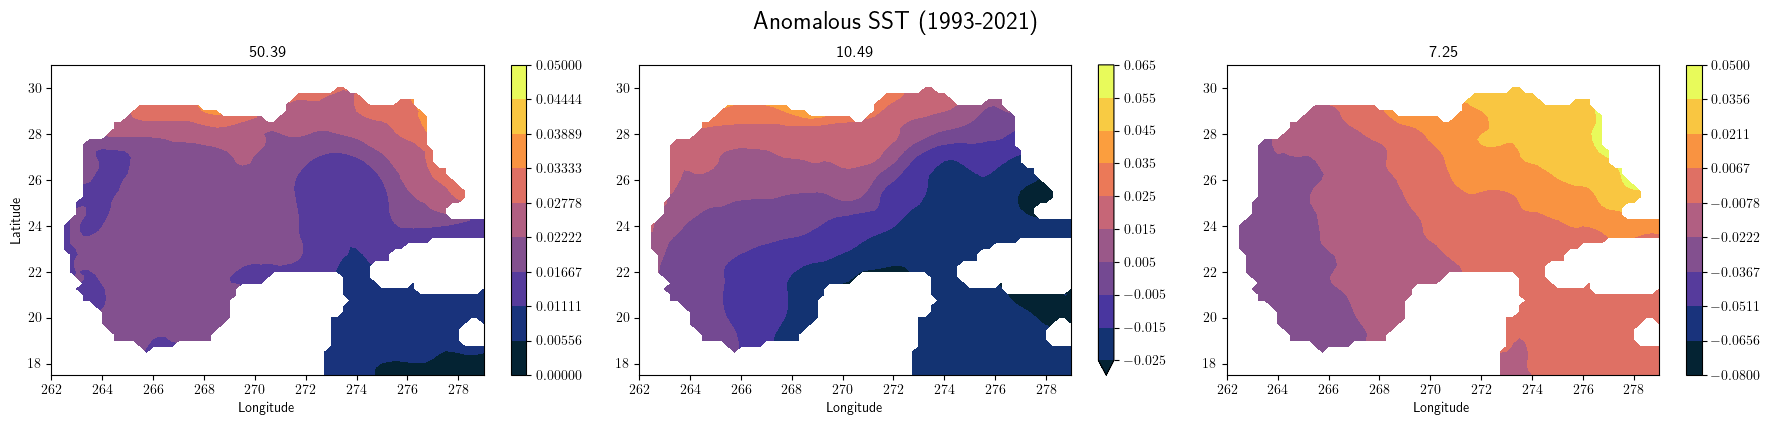

In [10]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sst_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0, 0.05, 10), 
                                                   cmap=cmocean.cm.thermal, cbar_kwargs={'label':''})
ax[0].set_title(f'{sst_eof.explained_variance_ratio[0].values*100:.2f} %')

sst_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.025, .065, 10), 
                                                   cmap=cmocean.cm.thermal, cbar_kwargs={'label':''})
ax[1].set_title(f'{sst_eof.explained_variance_ratio[1].values*100:.2f} %')

sst_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.08, .05, 10), 
                                                   cmap=cmocean.cm.thermal, cbar_kwargs={'label':''})
ax[2].set_title(f'{sst_eof.explained_variance_ratio[2].values*100:.2f} %')

ax[0].set_ylabel('Latitude')
[ax[i].set_ylabel('') for i in np.arange(1,3)]
[ax[i].set_xlabel('Longitude') for i in np.arange(0,3)]
plt.tight_layout()
st = plt.suptitle('Anomalous SST (1993-2021)', fontsize=18, fontweight='bold', y=1.05)
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/eof_sst.pdf', bbox_inches='tight', bbox_extra_artists=[st])